# Trabalho A1 - An√°lise de S√©ries Temporais

## Instru√ß√µes do Trabalho



**Linguagem de Programa√ß√£o:** Voc√™ pode utilizar Python ou R como linguagem de programa√ß√£o.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discuss√£o sobre m√©tricas e m√©todos de avalia√ß√£o**

* **Discuss√£o sobre a necessidade de transforma√ß√£o de vari√°veis**

* **Discuss√£o sobre a necessidade de decomposi√ß√£o entre tend√™ncia e sazonalidade**

* **An√°lises de res√≠duos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regress√£o linear m√∫ltipla** utilizando co-vari√°veis criadas baseadas nas vari√°veis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um reposit√≥rio no GitHub contendo o c√≥digo
- Relat√≥rio de no m√°ximo 5 p√°ginas contendo um resumo executivo das suas an√°lises


## Contexto

Ao longo do curso ser√° disponibilizado mais vari√°veis para melhorar os resultados obtidos na A1.

C√≥digo Python completo e bem comentado para an√°lise de s√©ries temporais do dataset `data.csv`.

Este script cobre:
 - An√°lise explorat√≥ria (visualiza√ß√µes e estat√≠sticas)
 - M√©tricas de avalia√ß√£o (MAE, RMSE, MAPE)
 - Transforma√ß√µes (log, Box-Cox, diferencia√ß√£o)
 - Testes de estacionariedade (ADF, KPSS)
 - Decomposi√ß√£o (trend/seasonal/residual)
 - Baselines (Naive, Seasonal Naive, Rolling mean)
 - Regress√£o linear m√∫ltipla com vari√°veis de tempo (tend√™ncia, sen/cos sazonais, dummies)
 - Modelos cl√°ssicos (ARIMA/SARIMA via pmdarima e statsmodels)
 - Diagn√≥stico de res√≠duos (ACF/PACF, Ljung-Box, histogramas)
 - Compara√ß√£o de modelos e exporta√ß√£o de resultados

# Imports

In [6]:
%%capture
import warnings
warnings.filterwarnings('ignore')

# import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression


from io import StringIO

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

#

# Fun√ß√µes Utilit√°rias

In [7]:
# Fun√ß√µes utilit√°rias

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred):
    # evitar divis√£o por zero ‚Äî retorna np.nan onde y_true==0
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def train_test_split_ts(df, test_size=0.2):
    # split temporal: √∫ltimos test_size (propor√ß√£o) usados como teste
    n = len(df)
    split = int(np.floor(n * (1 - test_size)))
    return df.iloc[:split].copy(), df.iloc[split:].copy()


# Carregamento dos dados

Os dados foram carregados na var√°vel `df` como um `pandas_datframe` e a vari√°vel `series`foi definida como uma Series pandas da vari√°vel volume

In [8]:
# Carregar dados
df = pd.read_csv('data.csv')

# indexando pelas datas
df['week_dt'] = pd.to_datetime(df['week'])
df.set_index('week_dt', inplace=True)
df.index.name = 'week'

# manter apenas coluna volume
series = df['volume'].astype(float)
series.name = 'volume'


## Discuss√£o sobre m√©tricas e m√©todos de avalia√ß√£o

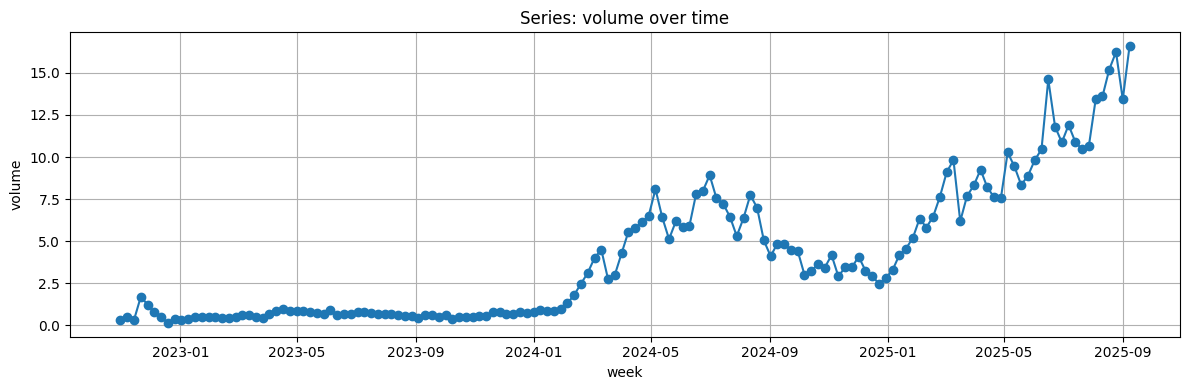

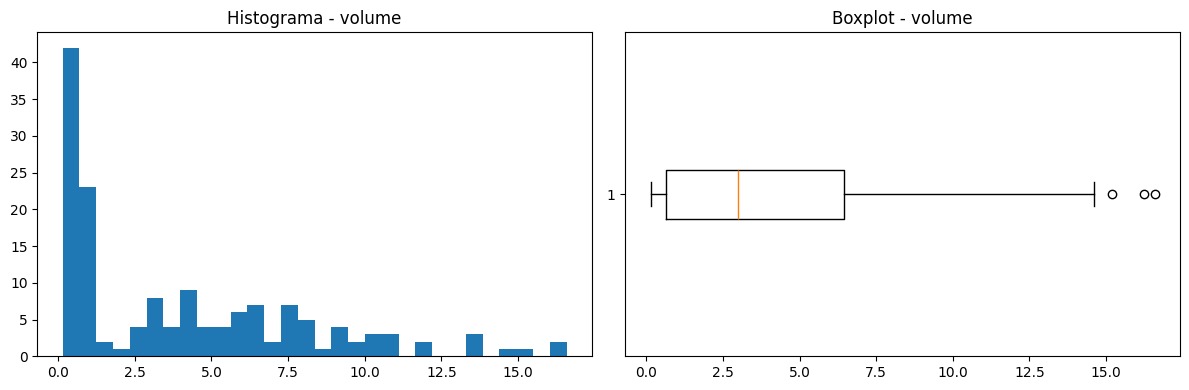

In [9]:
# An√°lise explorat√≥ria

plt.figure(figsize=(12,4))
plt.plot(series, marker='o', linestyle='-')
plt.title('Series: volume over time')
plt.ylabel('volume')
plt.xlabel('week')
plt.grid(True)
plt.tight_layout()
plt.show()

# histograma e boxplot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(series.dropna(), bins=30)
plt.title('Histograma - volume')
plt.subplot(1,2,2)
plt.boxplot(series.dropna(), vert=False)
plt.title('Boxplot - volume')
plt.tight_layout()
plt.show()


In [10]:
print("Intervalo dos dados:", series.min(),",", series.max())
print(len(series[series < 1]), "valores menores que 1", )

Intervalo dos dados: 0.14 , 16.59
64 valores menores que 1


# Modelos Baseline

<!-- Introdu√ß√£o -->
Modelos baseline s√£o modelos de previs√£o simples e f√°ceis de implementar que servem como um ponto de partida e **refer√™ncia** para avaliar o desempenho de modelos mais complexos.

Eles s√£o importantes porque:

1.  **Fornecem um ponto de compara√ß√£o:** Se um modelo sofisticado n√£o consegue superar um baseline simples (como a previs√£o ing√™nua), isso sugere que o modelo complexo n√£o est√° capturando bem os padr√µes da s√©rie, ou que a s√©rie √© inerentemente dif√≠cil de prever.
2.  **S√£o f√°ceis de entender e comunicar:** Seus resultados s√£o intuitivos e f√°ceis de explicar para n√£o especialistas.
3.  **Ajudam a identificar a dificuldade do problema:** Um baseline com erro muito alto indica que a s√©rie √© vol√°til e dif√≠cil de prever com m√©todos simples.
4.  **Garantem que o modelo complexo agrega valor:** Ao comparar as m√©tricas de erro (MAE, RMSE, MAPE) dos seus modelos de regress√£o ou SARIMA com as dos baselines, voc√™ pode quantificar o quanto seus modelos mais avan√ßados realmente melhoram a previs√£o.

Nesta se√ß√£o, implementaremos e avaliaremos alguns baselines comuns para ter essa refer√™ncia inicial de desempenho.

In [11]:
# Split treino/teste
train, test = train_test_split_ts(series.to_frame(), test_size=0.2)
train_s = train['volume']
test_s = test['volume']
print(f"\nTreino: {len(train_s)} obs, Teste: {len(test_s)} obs")


Treino: 120 obs, Teste: 30 obs


In [12]:
# Pr√©-configura√ß√£o para os modelos de baseline

# Lista para armazenar os resultados da avalia√ß√£o de todos os baselines
base_eval = []

# Par√¢metro para o Rolling Mean (n√∫mero de per√≠odos a serem considerados)
K = 4

### M√©todo da M√©dia (Mean Method)

Este m√©todo assume que a melhor previs√£o para o futuro √© simplesmente a m√©dia dos valores hist√≥ricos observados at√© o momento. A previs√£o para $h$ per√≠odos √† frente ($T+h$) √© dada por:

$\hat{y}_{T+h|T} = \bar{y} = \frac{y_1 + ... + y_T}{T}$

Onde:
- $\hat{y}_{T+h|T}$ √© a previs√£o para o per√≠odo $T+h$, feita no tempo $T$.
- $\bar{y}$ √© a m√©dia dos valores observados at√© o tempo $T$.
- $y_i$ √© o valor observado no tempo $i$.
- $T$ √© o n√∫mero total de observa√ß√µes hist√≥ricas.

Este m√©todo √© eficaz quando a s√©rie temporal n√£o apresenta uma tend√™ncia clara ou sazonalidade, e os valores futuros s√£o esperados em torno da m√©dia hist√≥rica. √â o baseline mais simples e serve para verificar se qualquer modelo mais complexo consegue superar a simples m√©dia hist√≥rica.

Mean Method Results:
  MAE: 7.9639
  RMSE: 8.4335
  MAPE: 74.2527%


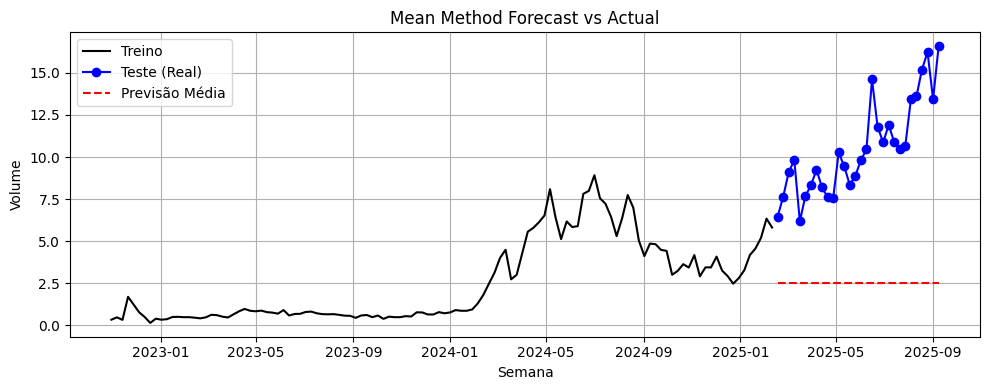

In [13]:
# Mean Method: predi√ß√£o = m√©dia de todo o treino

# Calcular a previs√£o (a m√©dia do treino repetida para o tamanho do teste)
mean_pred = np.repeat(train_s.mean(), len(test_s))

# Avaliar o baseline da M√©dia
mean_mae = mean_absolute_error(test_s, mean_pred)
mean_rmse = rmse(test_s, mean_pred)
mean_mape = mape(test_s, mean_pred)

# Armazenar os resultados
base_eval.append({'model': 'Mean', 'MAE': mean_mae, 'RMSE': mean_rmse, 'MAPE': mean_mape})

# Exibir os resultados para este baseline
print('Mean Method Results:')
print(f'  MAE: {mean_mae:.4f}')
print(f'  RMSE: {mean_rmse:.4f}')
print(f'  MAPE: {mean_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, mean_pred, label='Previs√£o M√©dia', color='red', linestyle='--')
plt.title('Mean Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### M√©todo Ing√™nuo ou Passeio Aleat√≥rio sem Tend√™ncia (Naive or Random Walk with No Drift)

Neste m√©todo, a previs√£o para o pr√≥ximo per√≠odo √© simplesmente o √∫ltimo valor observado. Este m√©todo √© conhecido como ‚Äúing√™nuo‚Äù porque assume que as mudan√ßas futuras ser√£o iguais √†s √∫ltimas observa√ß√µes, ou seja, que n√£o temos nenhum insight sistem√°tico sobre os valores futuros al√©m do valor mais recente. A previs√£o para $h$ per√≠odos √† frente √© dada por:

$\hat{y}_{T+h|T} = y_T$

Onde:
- $\hat{y}_{T+h|T}$ √© a previs√£o para o per√≠odo $T+h$, feita no tempo $T$.
- $y_T$ √© o √∫ltimo valor observado no tempo $T$.

Este baseline √© muito √∫til para s√©ries que se assemelham a um passeio aleat√≥rio. Se um modelo n√£o consegue superar o m√©todo ing√™nuo, isso pode indicar que a s√©rie √© muito vol√°til ou que o modelo n√£o est√° capturando adequadamente a estrutura de depend√™ncia temporal de curto prazo.

Naive Method Results:
  MAE: 4.6803
  RMSE: 5.4411
  MAPE: 40.7889%


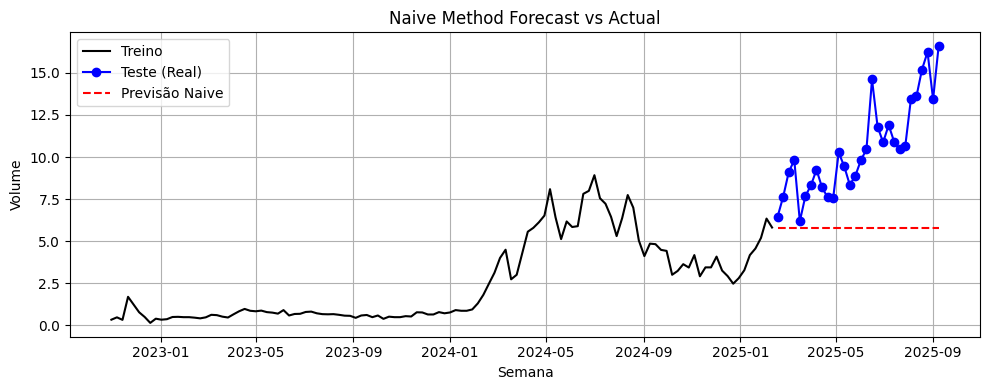

In [14]:
# Naive forecast: predi√ß√£o = √∫ltimo valor do treino

# Calcular a previs√£o (o √∫ltimo valor do treino repetido para o tamanho do teste)
naive_pred = np.repeat(train_s.iloc[-1], len(test_s))

# Avaliar o baseline Naive
naive_mae = mean_absolute_error(test_s, naive_pred)
naive_rmse = rmse(test_s, naive_pred)
naive_mape = mape(test_s, naive_pred)

# Armazenar os resultados
base_eval.append({'model': 'Naive', 'MAE': naive_mae, 'RMSE': naive_rmse, 'MAPE': naive_mape})

# Exibir os resultados para este baseline
print('Naive Method Results:')
print(f'  MAE: {naive_mae:.4f}')
print(f'  RMSE: {naive_rmse:.4f}')
print(f'  MAPE: {naive_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, naive_pred, label='Previs√£o Naive', color='red', linestyle='--')
plt.title('Naive Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### M√©todo Sazonal Ing√™nuo (Seasonal Naive)

Este m√©todo √© uma varia√ß√£o do m√©todo ing√™nuo, especialmente √∫til para s√©ries com forte sazonalidade conhecida. Ele prev√™ o valor para um per√≠odo futuro usando o valor observado no mesmo per√≠odo sazonal do ciclo anterior.

A previs√£o para o per√≠odo $T+h$ √© dada por:

$\hat{y}_{T+h|T} = y_{T+h-m}$

Onde:
- $\hat{y}_{T+h|T}$ √© a previs√£o para o per√≠odo $T+h$, feita no tempo $T$.
- $y_{T+h-m}$ √© o valor observado no mesmo per√≠odo sazonal ($m$) do ciclo anterior mais recente dispon√≠vel nos dados hist√≥ricos.
- $m$ √© o per√≠odo da sazonalidade (por exemplo, $m=12$ para dados mensais com sazonalidade anual, $m=52$ para dados semanais com sazonalidade anual).

Este baseline √© um forte concorrente para s√©ries com padr√µes sazonais consistentes. Se um modelo n√£o superar o Seasonal Naive para uma s√©rie sazonal, ele pode n√£o estar capturando bem o componente sazonal.

Seasonal Naive Method Results:
  MAE: 4.7593
  RMSE: 5.4027
  MAPE: 44.0100%


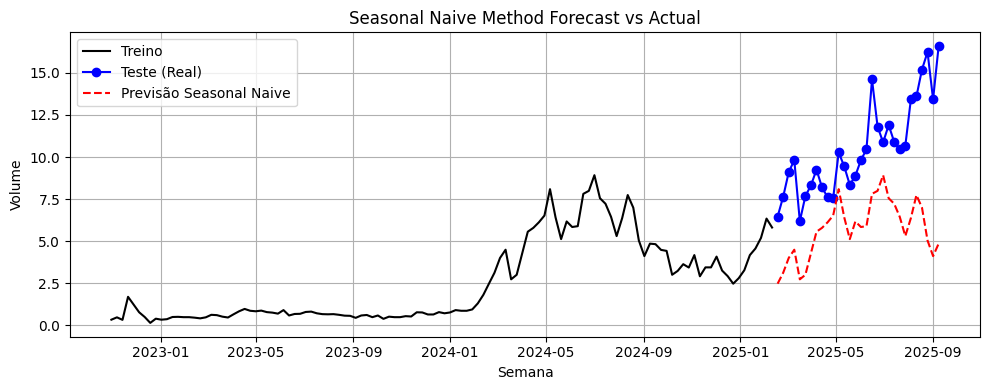

In [15]:
# Seasonal Naive: predi√ß√£o = valor de t-period

# Calcular a previs√£o sazonal ing√™nua
seasonal_naive_pred = []
SEASONAL_PERIOD = 52
if len(train_s) >= SEASONAL_PERIOD:
    for idx in test_s.index:
        # usar valor do mesmo periodo (periodo semanas) do √∫ltimo ano
        try:
            seasonal_naive_pred.append(train_s.loc[idx - pd.DateOffset(weeks=SEASONAL_PERIOD)])
        except Exception:
            # fallback: usar valor da posi√ß√£o -period relativa ao fim do treino
            # Isso s√≥ aconteceria se o per√≠odo de teste fosse muito grande
            # e extrapolasse os dados de treino dispon√≠veis para o ciclo sazonal anterior.
            # Para test_size < SEASONAL_PERIOD, o try deve funcionar.
            print(f"Warning: Fallback used for index {idx}")
            seasonal_naive_pred.append(train_s.iloc[-SEASONAL_PERIOD + (len(seasonal_naive_pred) % SEASONAL_PERIOD)])
    seasonal_naive_pred = np.array(seasonal_naive_pred)

    # Avaliar o baseline Seasonal Naive
    seasonal_naive_mae = mean_absolute_error(test_s, seasonal_naive_pred)
    seasonal_naive_rmse = rmse(test_s, seasonal_naive_pred)
    seasonal_naive_mape = mape(test_s, seasonal_naive_pred)

    # Armazenar os resultados
    base_eval.append({'model': 'SeasonalNaive', 'MAE': seasonal_naive_mae, 'RMSE': seasonal_naive_rmse, 'MAPE': seasonal_naive_mape})

    # Exibir os resultados para este baseline
    print('Seasonal Naive Method Results:')
    print(f'  MAE: {seasonal_naive_mae:.4f}')
    print(f'  RMSE: {seasonal_naive_rmse:.4f}')
    print(f'  MAPE: {seasonal_naive_mape:.4f}%')

    plt.figure(figsize=(10, 4))
    plt.plot(train_s.index, train_s, label='Treino', color='black')
    plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
    # Usar o √≠ndice do teste para a previs√£o sazonal, garantindo alinhamento temporal
    plt.plot(test_s.index, seasonal_naive_pred, label='Previs√£o Seasonal Naive', color='red', linestyle='--')
    plt.title('Seasonal Naive Method Forecast vs Actual')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print(f"N√£o √© poss√≠vel calcular o Seasonal Naive. Tamanho do treino ({len(train_s)}) √© menor que o per√≠odo sazonal ({SEASONAL_PERIOD}).")

M√©todo do Desvio (Drift Method)
O m√©todo do desvio √© utilizado para s√©ries temporais que seguem uma tend√™ncia linear ao
longo do tempo. Este m√©todo assume que a diferen√ßa entre observa√ß√µes consecutivas √©
constante, resultando em uma previs√£o que extrapola essa tend√™ncia:
yt = C + yt‚àí1 + Œµt
A previs√£o para h per√≠odos √† frente √© dada por:
^yT +h|T = yT + h ‚ãÖ C
Onde C representa o desvio m√©dio entre as observa√ß√µes:
C = ‚àëT
t=2(yt ‚àí yt‚àí1)
T ‚àí 1 = yT ‚àí y1
T ‚àí 1
Portanto, a previs√£o pode ser reescrita como:
^yT +h|T = yT + h ( yT ‚àí y1
T ‚àí 1 )
Este m√©todo √© √∫til para s√©ries que apresentam uma tend√™ncia consistente ao longo do tempo,
como crescimento linear.

### M√©todo do Desvio (Drift Method)

O m√©todo do desvio √© utilizado para s√©ries temporais que seguem uma tend√™ncia linear ao longo do tempo. Este m√©todo assume que a diferen√ßa m√©dia entre observa√ß√µes consecutivas √© constante, resultando em uma previs√£o que extrapola essa tend√™ncia:

$y_t = C + y_{t‚àí1} + \epsilon_t$

A previs√£o para $h$ per√≠odos √† frente √© dada por:

$\hat{y}_{T+h|T} = y_T + h \cdot C$

Onde $C$ representa o desvio m√©dio entre as observa√ß√µes no per√≠odo de treino:

$C = \frac{\sum_{t=2}^T (y_t ‚àí y_{t‚àí1})}{T ‚àí 1} = \frac{y_T ‚àí y_1}{T ‚àí 1}$

Portanto, a previs√£o pode ser reescrita como:

$\hat{y}_{T+h|T} = y_T + h \left( \frac{y_T ‚àí y_1}{T ‚àí 1} \right)$

Este m√©todo √© √∫til para s√©ries que apresentam uma tend√™ncia consistente ao longo do tempo, como crescimento linear. Ele √© mais robusto que o M√©todo Ing√™nuo para s√©ries com tend√™ncia, pois incorpora essa inclina√ß√£o m√©dia na previs√£o.

Drift Method Results:
  MAE: 3.9666
  RMSE: 4.6585
  MAPE: 34.3968%


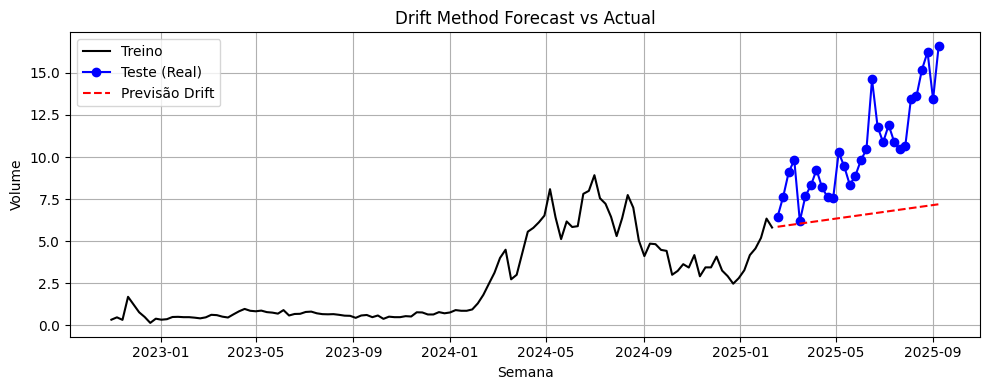

In [16]:
# Drift Method: predi√ß√£o = √∫ltimo valor + h * desvio m√©dio

# Calcular o desvio m√©dio no conjunto de treino
# Desvio = (√∫ltimo valor do treino - primeiro valor do treino) / (Tamanho do treino - 1)
if len(train_s) > 1:
    drift = (train_s.iloc[-1] - train_s.iloc[0]) / (len(train_s) - 1)
else:
    # Se o treino tem apenas 1 ponto, o desvio √© 0
    drift = 0
    print("Warning: Cannot calculate drift with only one training point. Drift set to 0.")


# Calcular a previs√£o para cada passo no conjunto de teste
# Previs√£o para h passos √† frente = √∫ltimo valor do treino + h * drift
drift_pred = []
last_train_value = train_s.iloc[-1]
for h in range(1, len(test_s) + 1):
    drift_pred.append(last_train_value + h * drift)
drift_pred = np.array(drift_pred)


# Avaliar o baseline Drift Method
drift_mae = mean_absolute_error(test_s, drift_pred)
drift_rmse = rmse(test_s, drift_pred)
drift_mape = mape(test_s, drift_pred)

# Armazenar os resultados
base_eval.append({'model': 'Drift', 'MAE': drift_mae, 'RMSE': drift_rmse, 'MAPE': drift_mape})

# Exibir os resultados para este baseline
print('Drift Method Results:')
print(f'  MAE: {drift_mae:.4f}')
print(f'  RMSE: {drift_rmse:.4f}')
print(f'  MAPE: {drift_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
# Usar o √≠ndice do teste para a previs√£o Drift, garantindo alinhamento temporal
plt.plot(test_s.index, drift_pred, label='Previs√£o Drift', color='red', linestyle='--')
plt.title('Drift Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### M√©todo da M√©dia M√≥vel (Rolling Mean)

O m√©todo da m√©dia m√≥vel utiliza a m√©dia dos √∫ltimos $K$ valores observados como previs√£o para o futuro. Ele suaviza as flutua√ß√µes de curto prazo e pode capturar tend√™ncias locais, mas n√£o lida bem com sazonalidade forte ou tend√™ncias de longo prazo.

A previs√£o para $h$ per√≠odos √† frente √© dada por:

$\hat{y}_{T+h|T} = \frac{y_{T} + y_{T-1} + ... + y_{T-K+1}}{K}$

Onde:
- $\hat{y}_{T+h|T}$ √© a previs√£o para o per√≠odo $T+h$, feita no tempo $T$.
- $y_i$ s√£o os valores observados.
- $K$ √© o n√∫mero de per√≠odos usados para calcular a m√©dia m√≥vel.

Este baseline √© mais reativo a mudan√ßas recentes na s√©rie do que o M√©todo da M√©dia simples. O par√¢metro $K$ pode ser ajustado; um $K$ menor torna a previs√£o mais responsiva a mudan√ßas recentes, enquanto um $K$ maior a torna mais suave.

Rolling Mean (k=4) Method Results:
  MAE: 5.0153
  RMSE: 5.7318
  MAPE: 44.2030%


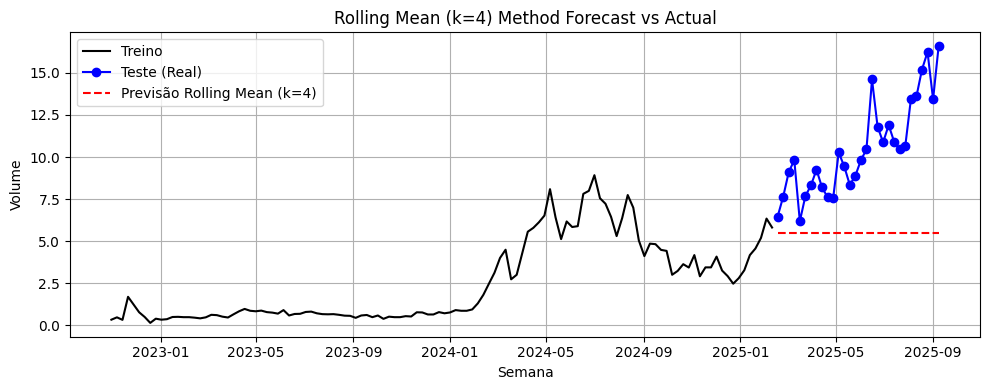

In [17]:
# Rolling mean (√∫ltimos k)

# Calcular a previs√£o (m√©dia dos √∫ltimos K valores do treino repetida para o tamanho do teste)
# K √© definido na c√©lula de pr√©-configura√ß√£o.
rolling_mean_pred = np.repeat(train_s.tail(K).mean(), len(test_s))

# Avaliar o baseline Rolling Mean
rolling_mean_mae = mean_absolute_error(test_s, rolling_mean_pred)
rolling_mean_rmse = rmse(test_s, rolling_mean_pred)
rolling_mean_mape = mape(test_s, rolling_mean_pred)

# Armazenar os resultados
base_eval.append({'model': f'RollingMean_k{K}', 'MAE': rolling_mean_mae, 'RMSE': rolling_mean_rmse, 'MAPE': rolling_mean_mape})

# Exibir os resultados para este baseline
print(f'Rolling Mean (k={K}) Method Results:')
print(f'  MAE: {rolling_mean_mae:.4f}')
print(f'  RMSE: {rolling_mean_rmse:.4f}')
print(f'  MAPE: {rolling_mean_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, rolling_mean_pred, label=f'Previs√£o Rolling Mean (k={K})', color='red', linestyle='--')
plt.title(f'Rolling Mean (k={K}) Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Comparativo final de todos os baselines

# Converter a lista de resultados em um DataFrame pandas
base_eval_df = pd.DataFrame(base_eval)

base_eval_df_sorted = base_eval_df.sort_values(by='RMSE').reset_index(drop=True)

print('\nComparativo de Modelos Baseline:')
display(base_eval_df_sorted)


Comparativo de Modelos Baseline:


model       MAE      RMSE       MAPE
0           Drift  3.966552  4.658450  34.396808
1   SeasonalNaive  4.759333  5.402674  44.010046
2           Naive  4.680333  5.441076  40.788894
3  RollingMean_k4  5.015333  5.731784  44.202960
4            Mean  7.963917  8.433490  74.252681

## Regress√£o linear m√∫ltipla

# Resumo dos Modelos de Regress√£o

An√°lise completa de s√©ries temporais, incluindo regress√£o linear m√∫ltipla e modelos SARIMAX, com diagn√≥stico de res√≠duos e compara√ß√£o de desempenho.

---

## 1. Regress√£o Linear M√∫ltipla (OLS)

### Estrutura do modelo
- **Vari√°vel dependente:** `volume` (s√©rie temporal)
- **Preditores utilizados:**
  - `t` ‚Üí tend√™ncia linear ao longo do tempo
  - Harm√¥nicos sazonais:
    - `sin1`, `cos1` ‚Üí 1¬∫ harm√¥nico (captura sazonalidade b√°sica)
    - `sin2`, `cos2` ‚Üí 2¬∫ harm√¥nico (captura sazonalidade mais complexa)
  - Dummies de m√™s (`m_2`, ..., `m_12`) ‚Üí capturam efeito fixo mensal
- **Intercepto** adicionado automaticamente pelo `sm.add_constant()`

### Objetivo
- Ajustar um modelo de regress√£o que capture **tend√™ncia + sazonalidade** de forma interpret√°vel.

### Diagn√≥stico de res√≠duos
- **ACF/PACF:** Verifica autocorrela√ß√£o nos res√≠duos ‚Üí idealmente devem ser ru√≠do branco.
- **Histograma:** Avalia normalidade aproximada.
- **QQ-Plot:** Compara√ß√£o com distribui√ß√£o normal.
- **Teste de Ljung-Box:** Detecta autocorrela√ß√£o residual significativa.
- **Resultados:** Res√≠duos podem indicar necessidade de incluir lags ou migrar para SARIMAX.

### Treino/Teste
- Conjunto de treino: 80% inicial da s√©rie.
- Conjunto de teste: √∫ltimas 12 semanas (`TEST_SIZE`).
- M√©tricas de performance no teste:
  - **RMSE**
  - **MAPE**
- Previs√µes geradas tanto para treino quanto para teste.

---

## 2. Modelos SARIMAX

### Estrutura
- Modelos ARIMA/SARIMA para capturar:
  - Autoregress√£o (AR)
  - Diferen√ßa (I)
  - M√©dia m√≥vel (MA)
  - Sazonalidade (P,D,Q,m)
- Ajuste via:
  - `pmdarima.auto_arima()` se dispon√≠vel (autom√°tico)
  - Grid search conservador manual com `statsmodels.SARIMAX`

### Objetivo
- Capturar depend√™ncias temporais que OLS n√£o consegue modelar, incluindo sazonalidade e autocorrela√ß√£o nos res√≠duos.

### Diagn√≥stico de res√≠duos
- Mesmos gr√°ficos do OLS:
  - ACF/PACF
  - Histograma
  - QQ-Plot
  - Ljung-Box
- Permite avaliar qualidade do ajuste SARIMAX.

### Forecasting
- Previs√£o das √∫ltimas 12 semanas.
- M√©tricas de performance:
  - **RMSE**
  - **MAPE**
- Compara√ß√£o direta com o modelo de regress√£o.

---

## 3. Compara√ß√£o de Modelos

| Modelo                                      | AIC   | BIC   | RMSE  | MAPE  |
|--------------------------------------------|-------|-------|-------|-------|
| Regress√£o (tend√™ncia + harm√¥nicos + m√™s)   | -     | -     | X.XXXX| X.XXXX|
| Melhor SARIMAX                              | XX.XX | XX.XX | X.XXXX| X.XXXX|

> **Observa√ß√µes:**
> - AIC/BIC s√≥ s√£o computados para modelos SARIMAX.
> - OLS √© avaliado por RMSE/MAPE no conjunto de teste.

---

## 4. Sa√≠da do Script

- **Relat√≥rios e plots gerados:**
  - `ols_summary.txt` ‚Üí resumo do modelo OLS
  - `ols_resid_acf.png`, `ols_resid_pacf.png`, `ols_resid_hist.png`, `ols_resid_qq.png`
  - `ols_ljungbox.csv` ‚Üí teste de Ljung-Box
  - `sarimax_summaries.txt` ‚Üí top SARIMAX models
  - `sarimax_resid_*` ‚Üí gr√°ficos de diagn√≥stico SARIMAX
  - `sarimax_ljungbox.csv`
  - `model_predictions_comparison.csv` ‚Üí compara√ß√£o de previs√µes OLS vs SARIMAX
  - `model_comparison.csv` ‚Üí m√©tricas finais
  - `readme_results.txt` ‚Üí resumo leg√≠vel dos resultados

---

**Conclus√£o:**
- O script combina **modelos de regress√£o interpret√°veis** (tend√™ncia + harm√¥nicos + dummies) com **modelos SARIMAX robustos** para capturar depend√™ncia temporal e sazonalidade.  
- Permite **diagn√≥stico completo** e **compara√ß√£o de performance**, salvando todas as informa√ß√µes para an√°lise posterior.


In [19]:
"""
An√°lise completa de s√©ries temporais com:
 - Regress√£o linear m√∫ltipla (tend√™ncia + harm√¥nicos sazonais + dummies de m√™s)
 - Modelos ARIMA/SARIMA (statsmodels; opcional: pmdarima.auto_arima)
 - Resultados para diagn√≥stico de res√≠duos (ACF/PACF, Ljung-Box, histograma, QQplot)
 - Compara√ß√£o por AIC/BIC/RMSE/MAPE
 - Exporta√ß√£o de resultados e plots

Salva resultados em ./results_linear_regression/
"""

import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Configura√ß√µes gerais
# -------------------------
OUTDIR = Path("./results_linear_regression")
OUTDIR.mkdir(parents=True, exist_ok=True)

data_csv = "data.csv"
# data_csv = """week,volume
#               2022-10-31,0.33
#               ...
#            """

INPUT_CSV_PATH = Path("data.csv")  # usado se data_csv for None

# Par√¢metros de modelagem
SEASONAL_PERIOD = 52        # sazonalidade anual em semanas (~52, uma ano)
TEST_SIZE = 12              # n√∫mero de semanas no conjunto de teste para valida√ß√£o
SARIMAX_GRID_SMALL = {
    "p": [0, 1, 2],
    "d": [0, 1],
    "q": [0, 1],
    "P": [0, 1],
    "D": [0, 1],
    "Q": [0, 1],
}


In [20]:
# -------------------------
# Fun√ß√µes utilit√°rias
# -------------------------
INPUT_CSV_PATH = "data.csv"  # caminho do arquivo local

def load_data():
    """Carrega os dados do CSV (arquivo) e prepara a s√©rie temporal."""
    df = pd.read_csv(INPUT_CSV_PATH, parse_dates=["week"])
    df = df.sort_values("week").reset_index(drop=True)
    df = df.set_index("week")
    df.index = pd.to_datetime(df.index)

    # Garantir num√©rico
    df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

    # Interpolar eventuais gaps (caso haja)
    df["volume"] = df["volume"].interpolate()

    return df



def evaluate(y_true, y_pred, model=None):
    """Calcula m√©tricas de avalia√ß√£o."""
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results = {"rmse": float(rmse), "mape": float(mape), "r2": float(r2)}

    if model is not None:
        results["r2_adj"] = float(model.rsquared_adj)
        results["std_err_reg"] = float(model.mse_resid ** 0.5)

    return results



In [21]:
# -------------------------
# Carregamento e features
# -------------------------
df = load_data()
df.to_csv(OUTDIR / "data_used.csv") # ordena por data, interpola se tiver valores faltantes.

data = df.reset_index()
T = len(data)
data["t"] = np.arange(1, T + 1)  # tend√™ncia (linear) , que cresce de 1 at√© T, para capturar crescimento/queda ao longo do tempo.

# Harm√¥nicos para sazonalidade (1¬∫ e 2¬∫ harm√¥nicos)
data["sin1"] = np.sin(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos1"] = np.cos(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["sin2"] = np.sin(4 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos2"] = np.cos(4 * np.pi * data["t"] / SEASONAL_PERIOD)

# Dummies para m√™s (poderia ser semana do ano, dia da semana, etc.)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True)
data = pd.concat([data, month_dummies], axis=1)
# print(data)

# Preditores para regress√£o
predictors = ["t", "sin1", "cos1", "sin2", "cos2"] + list(month_dummies.columns) # vari√°veis explicativas.
X_all = sm.add_constant(data[predictors]) # adiciona a constante (intercepto) ao modelo.
y_all = data["volume"] # vari√°vel resposta (a s√©rie volume).


# Criar preditores
t = np.arange(len(data))
X_all = pd.DataFrame({"t": t})
for k in range(1, 3):
    X_all[f"sin{k}"] = np.sin(2*np.pi*k*t/SEASONAL_PERIOD)
    X_all[f"cos{k}"] = np.cos(2*np.pi*k*t/SEASONAL_PERIOD)

# Dummies de m√™s (converter direto para float)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True).astype(float)

X_all = pd.concat([X_all, month_dummies], axis=1)
X_all = sm.add_constant(X_all).astype(float)

y_all = data["volume"].astype(float)


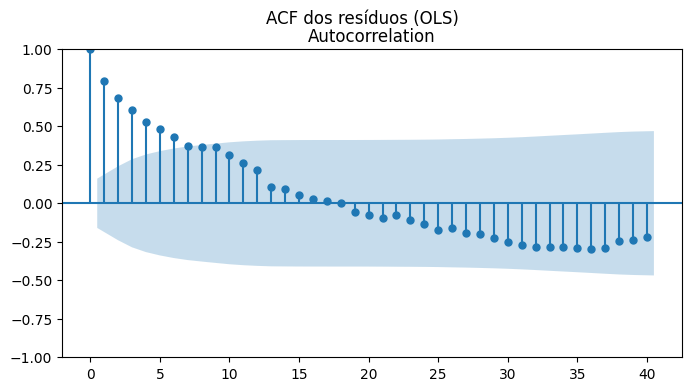

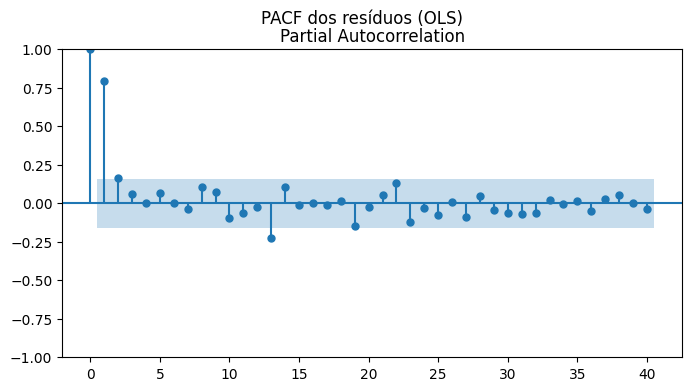

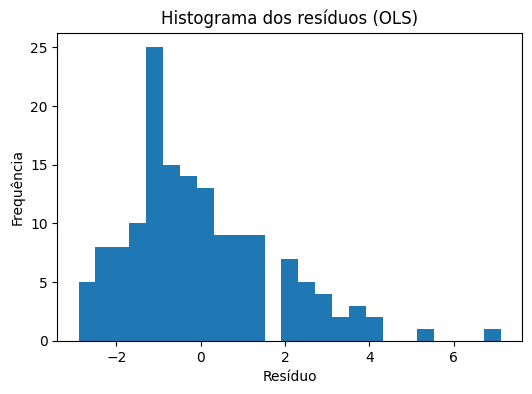

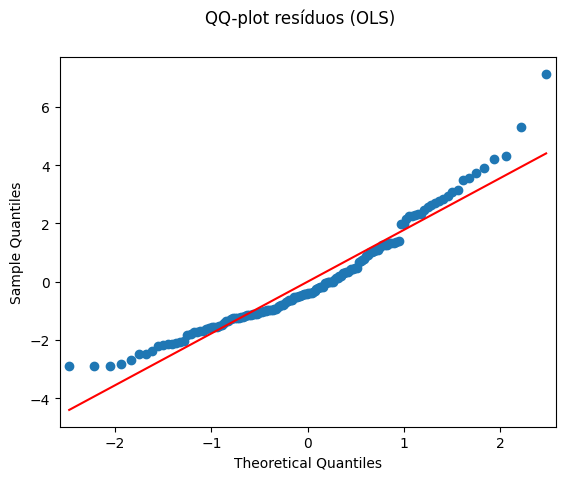

In [22]:
# -------------------------
# Regress√£o OLS (full sample)
# -------------------------

#Ajuste do modelo OLS (M√≠nimos Quadrados Ordin√°rios)
ols_full = sm.OLS(y_all, X_all).fit() #estima os coeficientes que minimizam a soma dos erros quadrados.
(OUTDIR / "ols_summary.txt").write_text(ols_full.summary().as_text()) # gera estat√≠sticas do modelo (coeficientes, R¬≤, p-values, etc.)

# Residual diagnostics (OLS)

#vetor de res√≠duos. S√£o usados para avaliar se o modelo capturou bem a estrutura da s√©rie.
resid = ols_full.resid

# ACF (Autocorrelation Function): mede se os res√≠duos est√£o correlacionados ao longo do tempo.
# Idealmente, res√≠duos devem ser ru√≠do branco ‚Üí sem autocorrela√ß√£o significativa.
# Se houver autocorrela√ß√£o, significa que o modelo n√£o capturou toda a depend√™ncia temporal.
fig = plt.figure(figsize=(8,4))
plot_acf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF dos res√≠duos (OLS)")
fig.savefig(OUTDIR / "ols_resid_acf.png")
plt.show()
plt.close(fig)

# PACF (Partial Autocorrelation Function): mostra a autocorrela√ß√£o de uma defasagem, condicionada √†s defasagens anteriores.
# Ajuda a detectar se ainda existe estrutura AR (autoregressiva) nos res√≠duos.
fig = plt.figure(figsize=(8,4))
plot_pacf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF dos res√≠duos (OLS)")
fig.savefig(OUTDIR / "ols_resid_pacf.png")
plt.show()
plt.close(fig)

# Histograma dos res√≠duos
# Verifica se os res√≠duos seguem uma distribui√ß√£o aproximadamente normal (hip√≥tese da regress√£o linear).
# Se houver caudas pesadas ou assimetria, pode indicar problemas no ajuste.
fig = plt.figure(figsize=(6,4))
plt.hist(resid, bins=25)
plt.title("Histograma dos res√≠duos (OLS)")
plt.xlabel("Res√≠duo"); plt.ylabel("Frequ√™ncia")
fig.savefig(OUTDIR / "ols_resid_hist.png")
plt.show()
plt.close(fig)

# QQ-plot (Quantile-Quantile)
# Compara os quantis dos res√≠duos com os quantis de uma distribui√ß√£o normal.
# Se os pontos seguirem a linha ‚Üí res√≠duos s√£o aproximadamente normais.
# Se houver desvios nas caudas ‚Üí problemas de heterocedasticidade ou n√£o-normalidade.
fig = qqplot(resid, line="s")
fig.suptitle("QQ-plot res√≠duos (OLS)")
fig.savefig(OUTDIR / "ols_resid_qq.png")
plt.show()
plt.close(fig)

# Teste de Ljung-Box
lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
lb.to_csv(OUTDIR / "ols_ljungbox.csv")


In [23]:
# -------------------------
# Treino / Teste (para comparar previs√µes)
# -------------------------

train = data.iloc[:-TEST_SIZE].copy()
test = data.iloc[-TEST_SIZE:].copy()

y_train = train["volume"]
y_test = test["volume"]

X_train = sm.add_constant(train[predictors])
X_test = sm.add_constant(test[predictors])

y_train = pd.to_numeric(y_train, errors="coerce").astype(float)
y_test = pd.to_numeric(y_test, errors="coerce").astype(float)

X_train = X_train.apply(pd.to_numeric, errors="coerce").astype(float)
X_test = X_test.apply(pd.to_numeric, errors="coerce").astype(float)



ols_train = sm.OLS(y_train, X_train).fit()
reg_pred = ols_train.predict(X_test)
reg_metrics = evaluate(y_test, reg_pred)

pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_true": y_test.values,
    "reg_pred": reg_pred.values
})


In [24]:
# -------------------------
# SARIMAX modeling
# - Tenta usar pmdarima.auto_arima se dispon√≠vel (mais pr√°tico)
# - Se n√£o, faz um grid search pequeno com statsmodels.SARIMAX
# -------------------------
use_auto = False
try:
    import pmdarima as pm
    use_auto = True
except Exception:
    use_auto = False

sarimax_results = []
if use_auto:
    # auto_arima (r√°pido se stepwise; precisa de pmdarima instalado)
    auto = pm.auto_arima(y_train, seasonal=True, m=SEASONAL_PERIOD,
                         stepwise=True, suppress_warnings=True, error_action="ignore")
    order = auto.order
    seasonal_order = auto.seasonal_order
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    sarimax_results.append({"model": f"AUTO ({order}) x {seasonal_order}", "aic": res.aic, "bic": res.bic, "res": res})
else:
    # Grid search conservador (ajuste os ranges em SARIMAX_GRID_SMALL para explorar mais)
    p_range = SARIMAX_GRID_SMALL["p"]
    d_range = SARIMAX_GRID_SMALL["d"]
    q_range = SARIMAX_GRID_SMALL["q"]
    P_range = SARIMAX_GRID_SMALL["P"]
    D_range = SARIMAX_GRID_SMALL["D"]
    Q_range = SARIMAX_GRID_SMALL["Q"]
    m = SEASONAL_PERIOD

    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                mod = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                                              enforce_stationarity=False, enforce_invertibility=False)
                                res = mod.fit(disp=False, low_memory=True)
                                sarimax_results.append({
                                    "model": f"SARIMAX ({p},{d},{q}) x ({P},{D},{Q},{m})",
                                    "aic": res.aic, "bic": res.bic, "res": res
                                })
                            except Exception as e:
                                # falhas de converg√™ncia s√£o normais em grid search; ignoramos
                                continue

# Se n√£o houve modelos (por falha), interrompa
if len(sarimax_results) == 0:
    raise RuntimeError("N√£o foi poss√≠vel ajustar nenhum modelo SARIMAX. Tente ajustar ranges menores ou instalar pmdarima.")

# Ordena por AIC e guarda top models
sarimax_results = sorted(sarimax_results, key=lambda x: x["aic"])
top_results = sarimax_results[:5]
# salva summaries
summaries_txt = ""
for i, item in enumerate(top_results):
    summaries_txt += f"Model {i+1}: {item['model']}  AIC={item['aic']:.2f}  BIC={item['bic']:.2f}\n"
    summaries_txt += item["res"].summary().as_text()
    summaries_txt += "\n\n" + ("-"*80) + "\n\n"
(OUTDIR / "sarimax_summaries.txt").write_text(summaries_txt)

# Escolhe o melhor para previs√µes (top_results[0])
best_res = top_results[0]["res"]

# Forecasting (est√°tico/determin√≠stico): preve as pr√≥ximas TEST_SIZE semanas
sarimax_forecast_obj = best_res.get_forecast(steps=TEST_SIZE)
sarimax_pred_mean = sarimax_forecast_obj.predicted_mean
# Alinha √≠ndices com as semanas reais do conjunto de teste
sarimax_pred_mean.index = test["week"].values

sarimax_metrics = evaluate(y_test, sarimax_pred_mean)

pred_df["sarimax_pred"] = sarimax_pred_mean.values
pred_df.to_csv(OUTDIR / "model_predictions_comparison.csv", index=False)


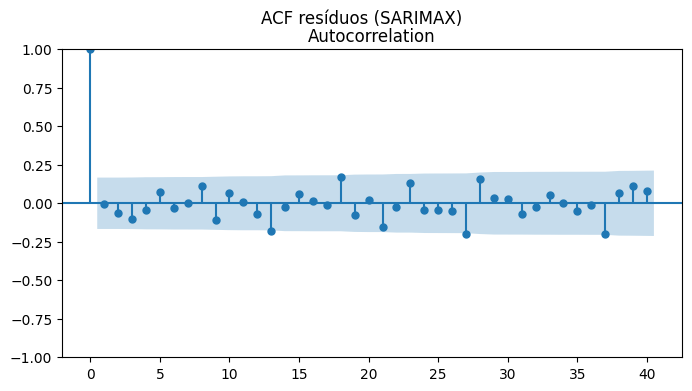

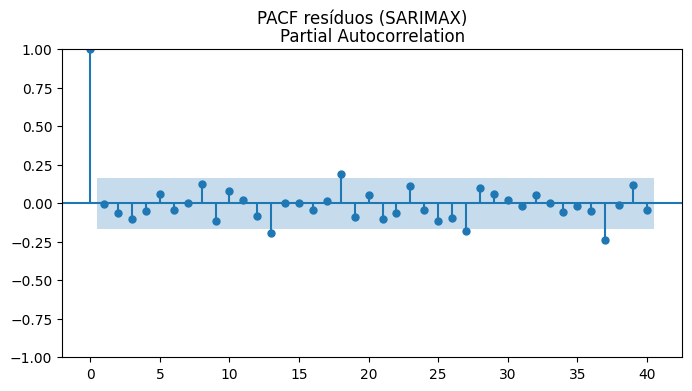

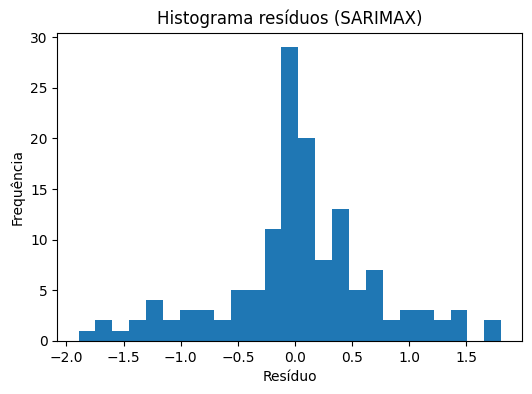

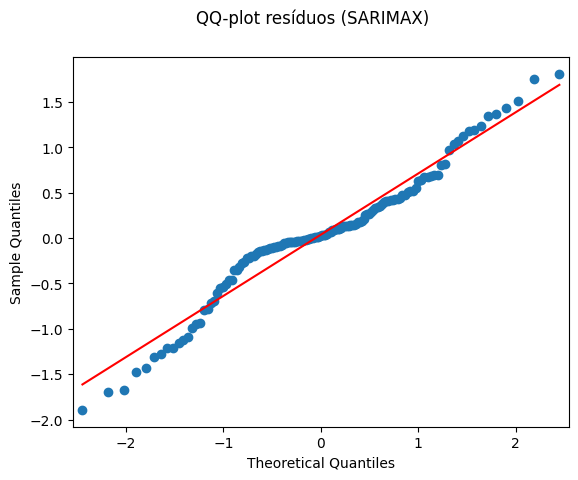

In [25]:

# Residual diagnostics (melhor SARIMAX)
resid_s = best_res.resid
fig = plt.figure(figsize=(8,4))
plot_acf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF res√≠duos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_acf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(8,4))
plot_pacf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF res√≠duos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_pacf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(6,4))
plt.hist(resid_s, bins=25)
plt.title("Histograma res√≠duos (SARIMAX)")
plt.xlabel("Res√≠duo"); plt.ylabel("Frequ√™ncia")
fig.savefig(OUTDIR / "sarimax_resid_hist.png")
plt.show()
plt.close(fig)

fig = qqplot(resid_s, line="s")
fig.suptitle("QQ-plot res√≠duos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_qq.png")
plt.show()
plt.close(fig)

lb_s = acorr_ljungbox(resid_s, lags=[10, 20], return_df=True)
lb_s.to_csv(OUTDIR / "sarimax_ljungbox.csv")




In [26]:
# -------------------------
# Compara√ß√£o final e salvamento
# -------------------------
comparison = pd.DataFrame([
    {
        "model": "Regression (trend+harmonics+month dummies)",
        "aic": np.nan, "bic": np.nan,
        "rmse": reg_metrics["rmse"], "mape": reg_metrics["mape"]
    },
    {
        "model": top_results[0]["model"],
        "aic": top_results[0]["aic"], "bic": top_results[0]["bic"],
        "rmse": sarimax_metrics["rmse"], "mape": sarimax_metrics["mape"]
    }
])
comparison.to_csv(OUTDIR / "model_comparison.csv", index=False)

# Save a short human-readable summary
summary = f"""
An√°lise completa salva em: {OUTDIR.resolve()}
Regress√£o (teste √∫ltimo {TEST_SIZE}): RMSE={reg_metrics['rmse']:.4f}, MAPE={reg_metrics['mape']:.4f}
SARIMAX (teste √∫ltimo {TEST_SIZE}): RMSE={sarimax_metrics['rmse']:.4f}, MAPE={sarimax_metrics['mape']:.4f}
Melhor SARIMAX: {top_results[0]['model']} (AIC={top_results[0]['aic']:.2f}, BIC={top_results[0]['bic']:.2f})
"""
(OUTDIR / "readme_results.txt").write_text(summary)
print(summary)

# Lista arquivos gerados
print("Arquivos gerados:")
for p in sorted(OUTDIR.iterdir()):
    print("-", p.name)



An√°lise completa salva em: C:\Users\dudda\Downloads\time-series\results_linear_regression
Regress√£o (teste √∫ltimo 12): RMSE=5.1834, MAPE=0.3303
SARIMAX (teste √∫ltimo 12): RMSE=3.2793, MAPE=0.2212
Melhor SARIMAX: SARIMAX (0,1,1) x (0,1,1,52) (AIC=83.05, BIC=87.36)

Arquivos gerados:
- data_used.csv
- forecast_comparison.png
- model_comparison.csv
- model_predictions_comparison.csv
- ols_ljungbox.csv
- ols_resid_acf.png
- ols_resid_hist.png
- ols_resid_pacf.png
- ols_resid_qq.png
- ols_summary.txt
- readme_results.txt
- sarimax_ljungbox.csv
- sarimax_resid_acf.png
- sarimax_resid_hist.png
- sarimax_resid_pacf.png
- sarimax_resid_qq.png
- sarimax_summaries.txt


In [27]:
# garante que 'week' est√° em datetime
df_check["week"] = pd.to_datetime(df_check["week"])

plt.figure(figsize=(12,6))
plt.plot(df_check["week"], df_check["volume"], marker="o", linestyle="-", color="black")

plt.title("S√©rie Temporal Original - Volume por Semana")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'df_check' is not defined

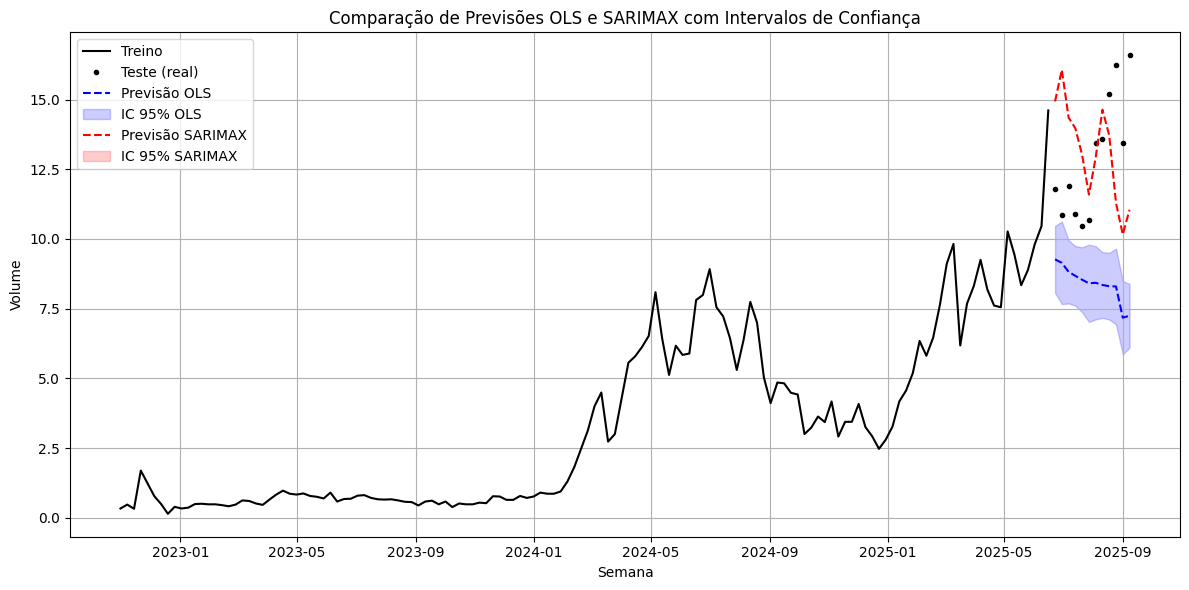

In [28]:
# -------------------------
# Preparar previs√µes com IC
# -------------------------

# 1Ô∏è Previs√£o OLS
ols_forecast_obj = ols_train.get_prediction(X_test)
ols_pred_mean = ols_forecast_obj.predicted_mean
ols_ci = ols_forecast_obj.conf_int(alpha=0.05)

ols_pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_pred": ols_pred_mean,
    "ci_lower": ols_ci[:, 0],
    "ci_upper": ols_ci[:, 1]
})

# 2Ô∏è Previs√£o SARIMAX
sarimax_forecast_obj = best_res.get_forecast(steps=len(test))
sarimax_forecast_df = sarimax_forecast_obj.summary_frame(alpha=0.05)

# Garantir alinhamento correto com o eixo x
sarimax_pred_df = sarimax_forecast_df.copy()
sarimax_pred_df["week"] = test["week"].values
sarimax_pred_df.rename(columns={
    "mean": "y_pred",
    "mean_ci_lower": "ci_lower",
    "mean_ci_upper": "ci_upper"
}, inplace=True)

# -------------------------
# Plotagem
# -------------------------
plt.figure(figsize=(12,6))

# Treino
plt.plot(train["week"], train["volume"], color="black", linestyle="-", label="Treino")

# Teste (real)
plt.plot(test["week"], test["volume"], color="black", marker=".", linestyle="None", label="Teste (real)")

# OLS
plt.plot(ols_pred_df["week"], ols_pred_df["y_pred"], color="blue", linestyle="--", label="Previs√£o OLS")
plt.fill_between(ols_pred_df["week"], ols_pred_df["ci_lower"], ols_pred_df["ci_upper"],
                 color="blue", alpha=0.2, label="IC 95% OLS")

# SARIMAX
plt.plot(sarimax_pred_df["week"], sarimax_pred_df["y_pred"], color="red", linestyle="--", label="Previs√£o SARIMAX")
plt.fill_between(sarimax_pred_df["week"], sarimax_pred_df["ci_lower"], sarimax_pred_df["ci_upper"],
                 color="red", alpha=0.2, label="IC 95% SARIMAX")

# Estilo e labels
plt.title("Compara√ß√£o de Previs√µes OLS e SARIMAX com Intervalos de Confian√ßa")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Salvar e mostrar
plt.savefig(OUTDIR / "forecast_comparison.png")
plt.show()
plt.close()


# An√°lise de res√≠duos e ajuste dos modelos

In [29]:
# Configura√ß√µes de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


 EXECUTANDO AN√ÅLISE DE RES√çDUOS...
 INICIANDO AN√ÅLISE DE RES√çDUOS...

 VERIFICA√á√ÉO DE TAMANHOS:
   Mean: 30 previs√µes
   Naive: 30 previs√µes
   SeasonalNaive: 30 previs√µes
   Drift: 30 previs√µes
   RollingMean_k4: 30 previs√µes
   Regression: 12 previs√µes
   SARIMAX: 12 previs√µes
   Teste: 12 observa√ß√µes
   Treino: 138 observa√ß√µes

################################################################################
ANALISANDO MODELO: Mean
################################################################################
  Ajustando tamanho das previs√µes para Mean: 30 -> 12
 Tamanhos - Res√≠duos: 12, Fitted: 12, Actual: 12

AN√ÅLISE DE RES√çDUOS - Mean
Gr√°fico salvo em: residuals_analysis\residuals_analysis_mean.png


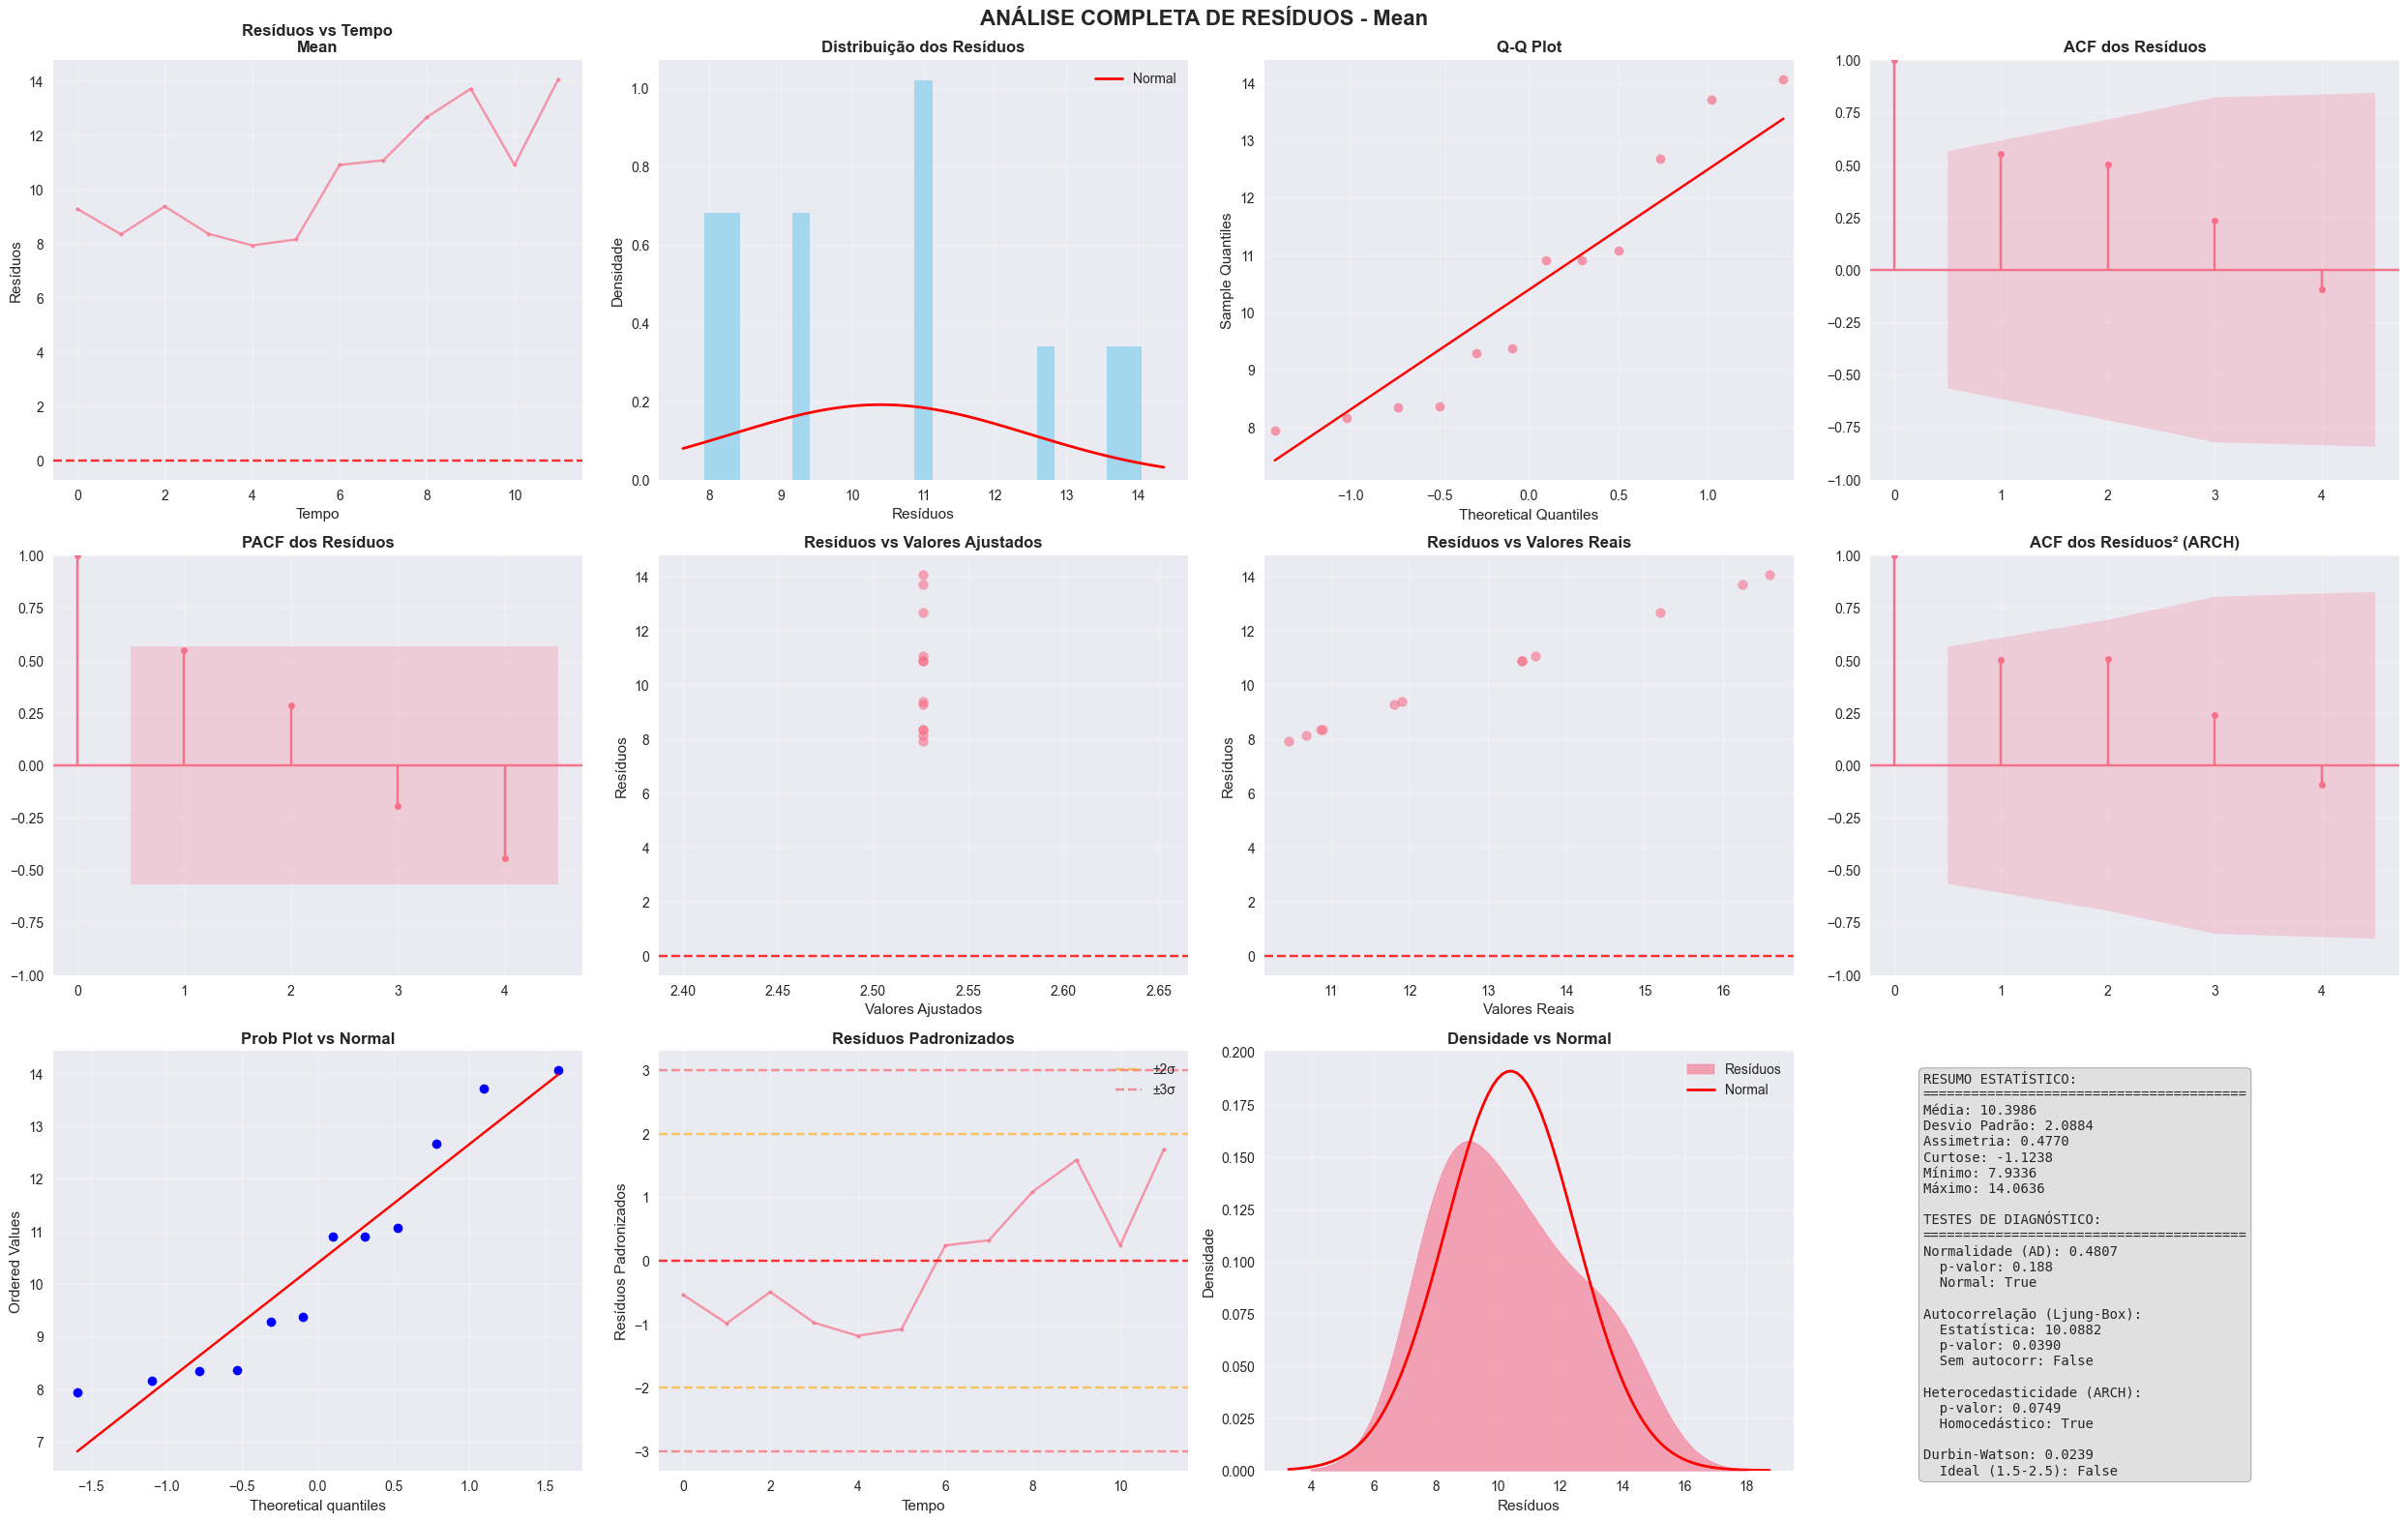


 DIAGN√ìSTICO DOS RES√çDUOS:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X M√©dia zero
OK Normalidade
X Sem autocorrela√ß√£o
OK Homocedasticidade
X Durbin-Watson

 ESTAT√çSTICAS CHAVE:
   ‚Ä¢ RMSE dos res√≠duos: 10.6062
   ‚Ä¢ MAE dos res√≠duos: 10.3986
   ‚Ä¢ Assimetria: 0.4770
   ‚Ä¢ Curtose: -1.1238

 RECOMENDA√á√ïES:
   ‚Ä¢ Autocorrela√ß√£o detectada - modelo pode capturar padr√µes inadequados
   ‚Ä¢ Autocorrela√ß√£o positiva - subestima√ß√£o do erro padr√£o

################################################################################
ANALISANDO MODELO: Naive
################################################################################
  Ajustando tamanho das previs√µes para Naive: 30 -> 12
 Tamanhos - Res√≠duos: 12, Fitted: 12, Actual: 12

AN√ÅLISE DE RES√çDUOS - Naive
Gr√°fico salvo em: residuals_analysis\residuals_analysis_naive.png


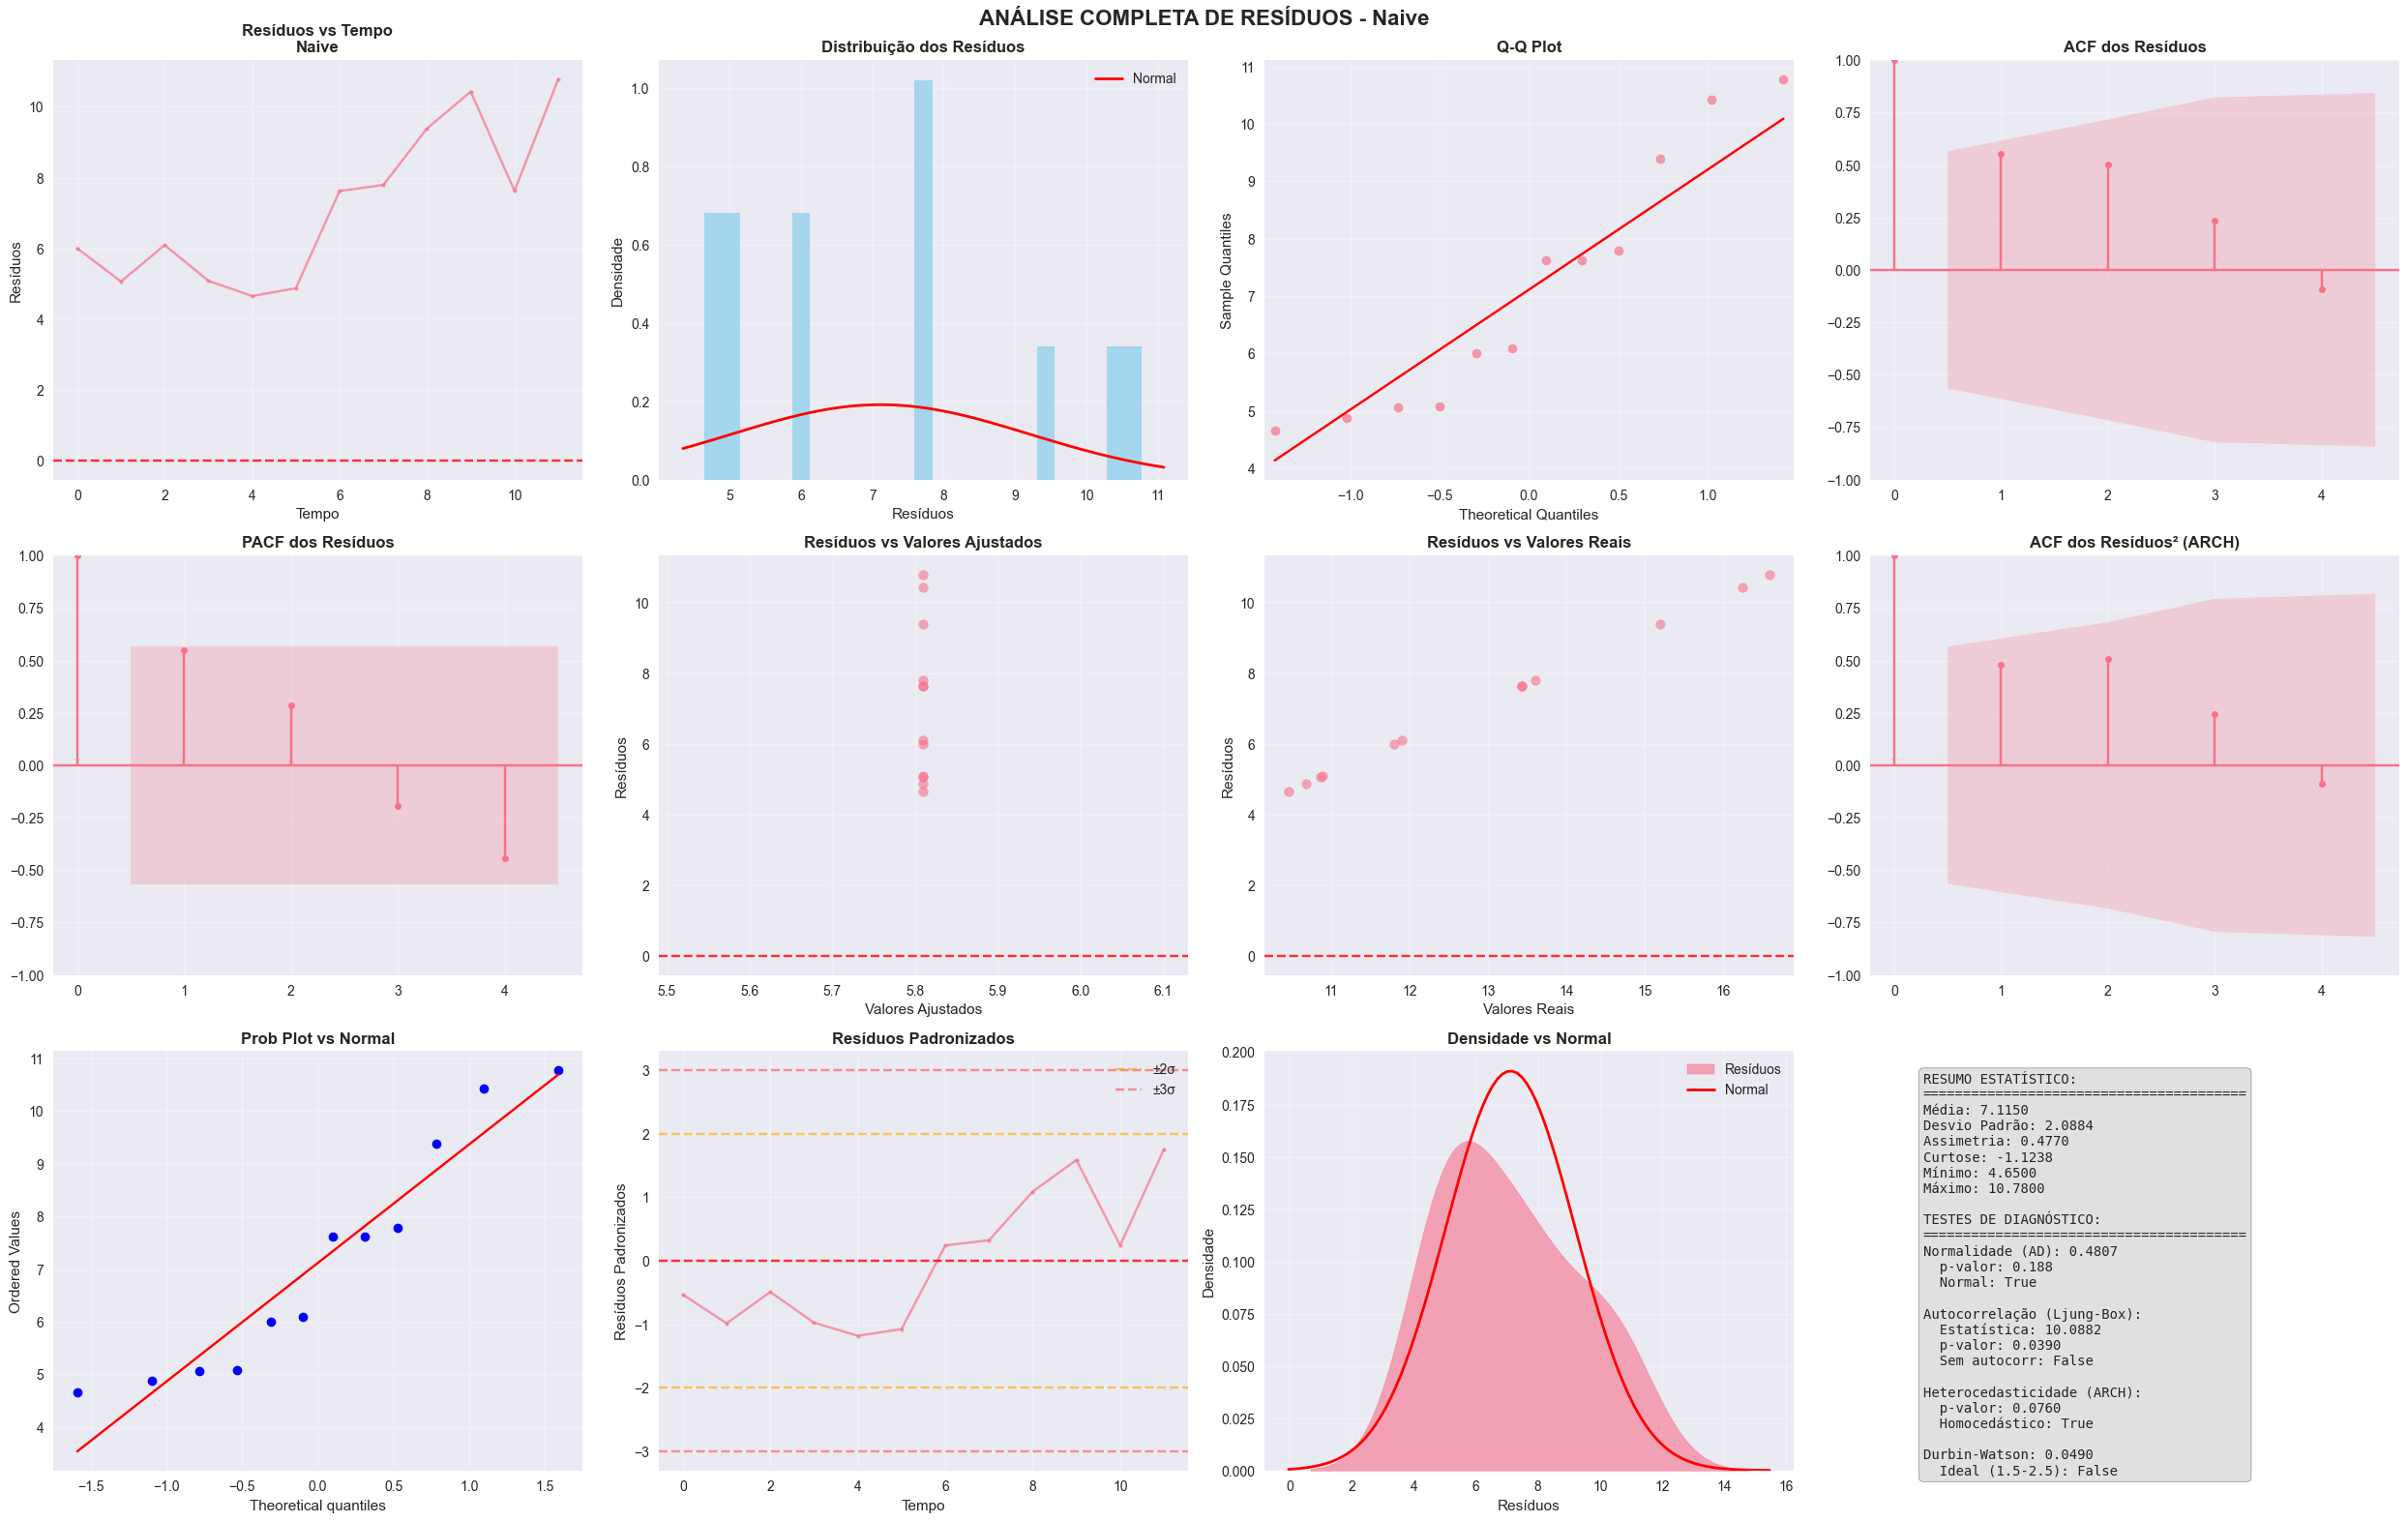


 DIAGN√ìSTICO DOS RES√çDUOS:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X M√©dia zero
OK Normalidade
X Sem autocorrela√ß√£o
OK Homocedasticidade
X Durbin-Watson

 ESTAT√çSTICAS CHAVE:
   ‚Ä¢ RMSE dos res√≠duos: 7.4152
   ‚Ä¢ MAE dos res√≠duos: 7.1150
   ‚Ä¢ Assimetria: 0.4770
   ‚Ä¢ Curtose: -1.1238

 RECOMENDA√á√ïES:
   ‚Ä¢ Autocorrela√ß√£o detectada - modelo pode capturar padr√µes inadequados
   ‚Ä¢ Autocorrela√ß√£o positiva - subestima√ß√£o do erro padr√£o

################################################################################
ANALISANDO MODELO: SeasonalNaive
################################################################################
  Ajustando tamanho das previs√µes para SeasonalNaive: 30 -> 12
 Tamanhos - Res√≠duos: 12, Fitted: 12, Actual: 12

AN√ÅLISE DE RES√çDUOS - SeasonalNaive
Gr√°fico salvo em: residuals_analysis\residuals_analysis_seasonalnaive.png


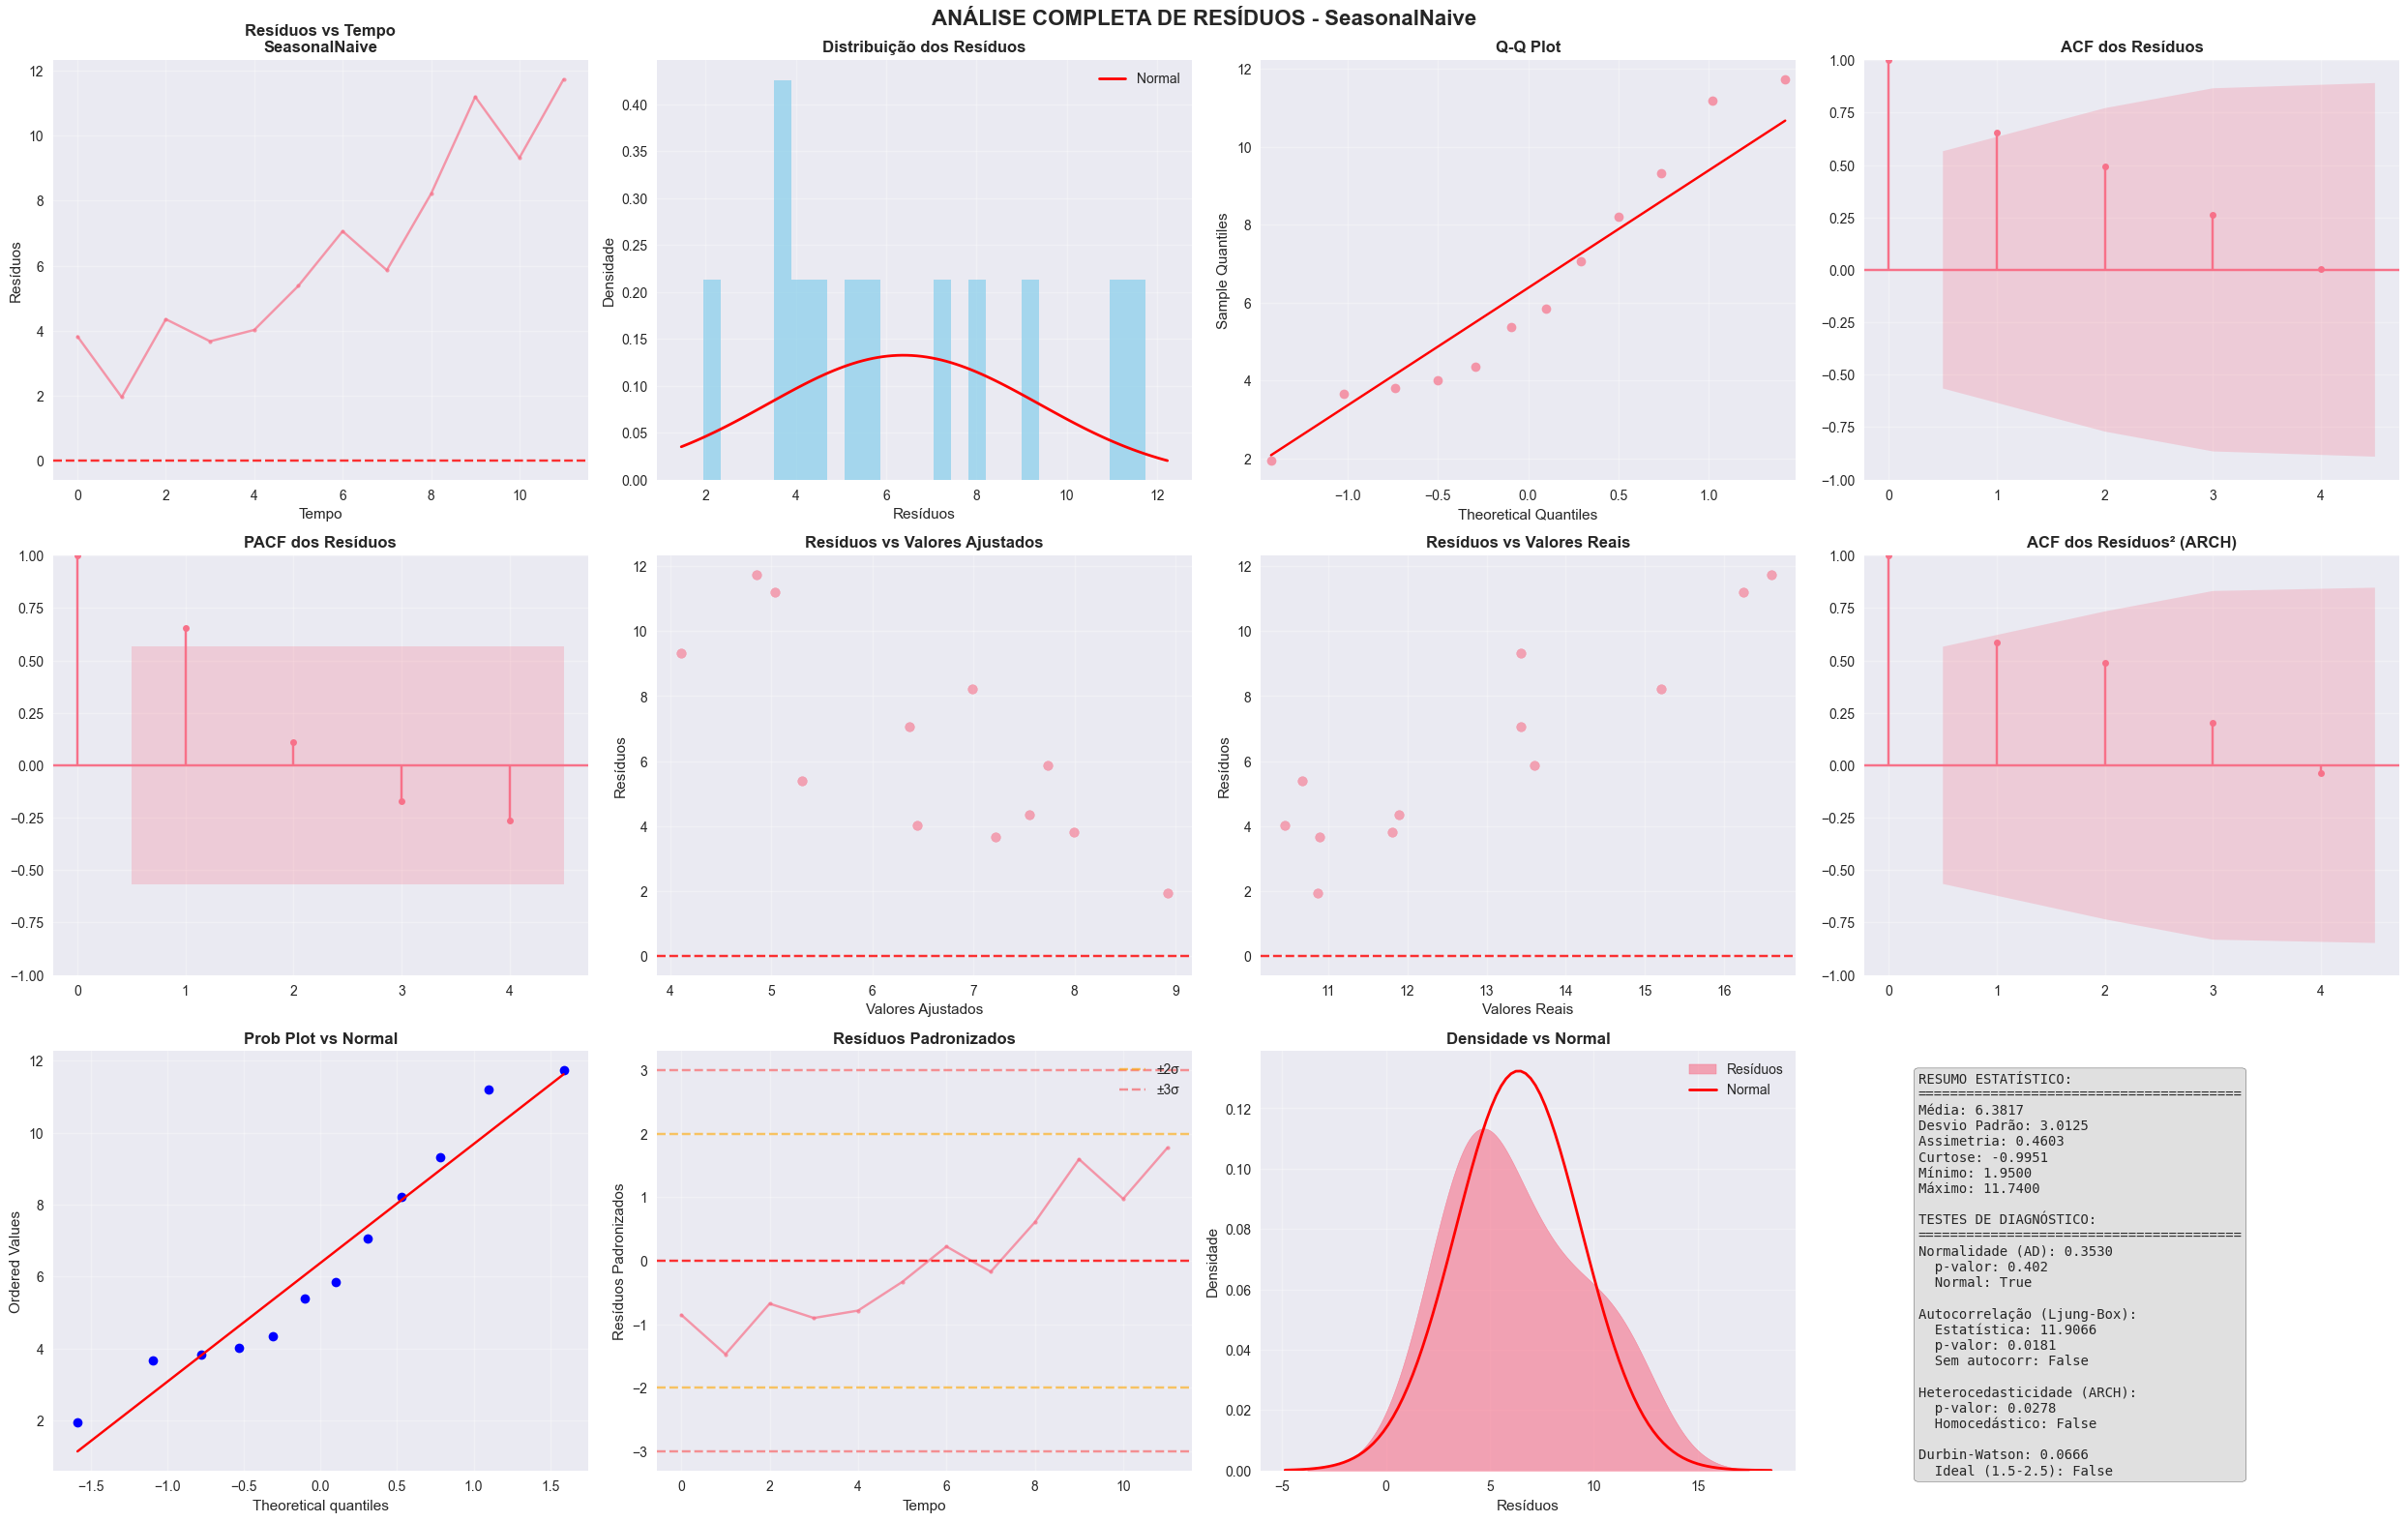


 DIAGN√ìSTICO DOS RES√çDUOS:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X M√©dia zero
OK Normalidade
X Sem autocorrela√ß√£o
X Homocedasticidade
X Durbin-Watson

 ESTAT√çSTICAS CHAVE:
   ‚Ä¢ RMSE dos res√≠duos: 7.0570
   ‚Ä¢ MAE dos res√≠duos: 6.3817
   ‚Ä¢ Assimetria: 0.4603
   ‚Ä¢ Curtose: -0.9951

 RECOMENDA√á√ïES:
   ‚Ä¢ Autocorrela√ß√£o detectada - modelo pode capturar padr√µes inadequados
   ‚Ä¢ Heterocedasticidade detectada - vari√¢ncia n√£o constante
   ‚Ä¢ Autocorrela√ß√£o positiva - subestima√ß√£o do erro padr√£o

################################################################################
ANALISANDO MODELO: Drift
################################################################################
  Ajustando tamanho das previs√µes para Drift: 30 -> 12
 Tamanhos - Res√≠duos: 12, Fitted: 12, Actual: 12

AN√ÅLISE DE RES√çDUOS - Drift


In [ ]:
class ResidualAnalysis:
    """
    Classe completa para an√°lise de res√≠duos de modelos de s√©ries temporais
    """
    
    def __init__(self, model_name, residuals, fitted_values, actual_values, model_obj=None):
        self.model_name = model_name
        self.residuals = np.array(residuals)
        self.fitted_values = np.array(fitted_values)
        self.actual_values = np.array(actual_values)
        self.model_obj = model_obj
        self.analysis_results = {}
        
    def comprehensive_residual_analysis(self, lags=20, save_path=None):
        """
        Realiza an√°lise completa dos res√≠duos
        """
        print(f"\n{'='*60}")
        print(f"AN√ÅLISE DE RES√çDUOS - {self.model_name}")
        print(f"{'='*60}")
        
        # 1. Testes estat√≠sticos formais
        self._formal_tests(lags)
        
        # 2. An√°lise gr√°fica completa
        self._plot_comprehensive_analysis(lags, save_path)
        
        # 3. Diagn√≥stico resumido
        self._print_diagnostic_summary()
        
        return self.analysis_results
    
    def _formal_tests(self, lags):
        """Executa testes estat√≠sticos formais nos res√≠duos"""
        
        # Teste de normalidade (Anderson-Darling) - CORRIGIDO
        try:
            from statsmodels.stats.diagnostic import normal_ad
            ad_stat, ad_pvalue = normal_ad(self.residuals)
            # Valores cr√≠ticos para teste de Anderson-Darling (n√≠vel 5%)
            ad_critical_5percent = 0.787  # Valor cr√≠tico aproximado para 5%
            self.analysis_results['normality_ad'] = {
                'statistic': ad_stat,
                'p_value': ad_pvalue,
                'critical_5percent': ad_critical_5percent,
                'is_normal': ad_pvalue > 0.05  # p-value > 0.05 indica normalidade
            }
        except Exception as e:
            print(f"Erro no teste de normalidade: {e}")
            self.analysis_results['normality_ad'] = {
                'statistic': np.nan,
                'p_value': np.nan,
                'critical_5percent': np.nan,
                'is_normal': np.nan
            }
        
        # Teste de autocorrela√ß√£o (Ljung-Box)
        try:
            lb_test = acorr_ljungbox(self.residuals, lags=[lags], return_df=True)
            self.analysis_results['ljung_box'] = {
                'statistic': lb_test['lb_stat'].iloc[0],
                'p_value': lb_test['lb_pvalue'].iloc[0],
                'no_autocorr': lb_test['lb_pvalue'].iloc[0] > 0.05
            }
        except Exception as e:
            print(f"Erro no teste Ljung-Box: {e}")
            self.analysis_results['ljung_box'] = {
                'statistic': np.nan,
                'p_value': np.nan,
                'no_autocorr': np.nan
            }
        
        # Teste de heterocedasticidade (ARCH)
        try:
            arch_test = het_arch(self.residuals)
            self.analysis_results['arch_test'] = {
                'statistic': arch_test[0],
                'p_value': arch_test[1],
                'is_homoscedastic': arch_test[1] > 0.05
            }
        except Exception as e:
            print(f"Erro no teste ARCH: {e}")
            self.analysis_results['arch_test'] = {
                'statistic': np.nan,
                'p_value': np.nan,
                'is_homoscedastic': np.nan
            }
        
        # Teste de Durbin-Watson (autocorrela√ß√£o de ordem 1)
        try:
            dw_stat = durbin_watson(self.residuals)
            self.analysis_results['durbin_watson'] = {
                'statistic': dw_stat,
                'no_autocorr': 1.5 <= dw_stat <= 2.5  # Ideal entre 1.5 e 2.5
            }
        except Exception as e:
            print(f"Erro no teste Durbin-Watson: {e}")
            self.analysis_results['durbin_watson'] = {
                'statistic': np.nan,
                'no_autocorr': np.nan
            }
        
        # Estat√≠sticas descritivas dos res√≠duos
        try:
            self.analysis_results['descriptive_stats'] = {
                'mean': np.mean(self.residuals),
                'std': np.std(self.residuals),
                'skewness': stats.skew(self.residuals),
                'kurtosis': stats.kurtosis(self.residuals),
                'min': np.min(self.residuals),
                'max': np.max(self.residuals)
            }
        except Exception as e:
            print(f"Erro nas estat√≠sticas descritivas: {e}")
            self.analysis_results['descriptive_stats'] = {
                'mean': np.nan, 'std': np.nan, 'skewness': np.nan,
                'kurtosis': np.nan, 'min': np.nan, 'max': np.nan
            }
        
        # Teste se m√©dia √© zero (t-test)
        try:
            t_stat, p_value = stats.ttest_1samp(self.residuals, 0)
            self.analysis_results['mean_test'] = {
                't_statistic': t_stat,
                'p_value': p_value,
                'mean_zero': p_value > 0.05
            }
        except Exception as e:
            print(f"Erro no teste de m√©dia zero: {e}")
            self.analysis_results['mean_test'] = {
                't_statistic': np.nan,
                'p_value': np.nan,
                'mean_zero': np.nan
            }
    
    def _plot_comprehensive_analysis(self, lags, save_path):
        """Gera gr√°ficos completos de an√°lise de res√≠duos"""
        
        fig = plt.figure(figsize=(25, 16))
        
        # 1. Res√≠duos vs Tempo
        ax1 = plt.subplot(3, 4, 1)
        plt.plot(self.residuals, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title(f'Res√≠duos vs Tempo\n{self.model_name}', fontsize=12, fontweight='bold')
        plt.xlabel('Tempo')
        plt.ylabel('Res√≠duos')
        plt.grid(True, alpha=0.3)
        
        # 2. Histograma + Distribui√ß√£o Normal
        ax2 = plt.subplot(3, 4, 2)
        n, bins, patches = plt.hist(self.residuals, bins=25, density=True, alpha=0.7, color='skyblue')
        
        # Sobrepor distribui√ß√£o normal
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, np.mean(self.residuals), np.std(self.residuals))
        plt.plot(x, p, 'r-', linewidth=2, label='Normal')
        plt.title('Distribui√ß√£o dos Res√≠duos', fontsize=12, fontweight='bold')
        plt.xlabel('Res√≠duos')
        plt.ylabel('Densidade')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. QQ-Plot
        ax3 = plt.subplot(3, 4, 3)
        qqplot(self.residuals, line='s', ax=ax3, alpha=0.7)
        plt.title('Q-Q Plot', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 4. ACF dos Res√≠duos
        ax4 = plt.subplot(3, 4, 4)
        plot_acf(self.residuals, lags=lags, ax=ax4, alpha=0.05)
        plt.title('ACF dos Res√≠duos', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 5. PACF dos Res√≠duos
        ax5 = plt.subplot(3, 4, 5)
        plot_pacf(self.residuals, lags=lags, ax=ax5, alpha=0.05)
        plt.title('PACF dos Res√≠duos', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 6. Res√≠duos vs Valores Ajustados
        ax6 = plt.subplot(3, 4, 6)
        plt.scatter(self.fitted_values, self.residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title('Res√≠duos vs Valores Ajustados', fontsize=12, fontweight='bold')
        plt.xlabel('Valores Ajustados')
        plt.ylabel('Res√≠duos')
        plt.grid(True, alpha=0.3)
        
        # 7. Res√≠duos vs Valores Reais
        ax7 = plt.subplot(3, 4, 7)
        plt.scatter(self.actual_values, self.residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title('Res√≠duos vs Valores Reais', fontsize=12, fontweight='bold')
        plt.xlabel('Valores Reais')
        plt.ylabel('Res√≠duos')
        plt.grid(True, alpha=0.3)
        
        # 8. ACF dos Res√≠duos Quadrados (para detectar ARCH)
        ax8 = plt.subplot(3, 4, 8)
        squared_residuals = self.residuals ** 2
        plot_acf(squared_residuals, lags=lags, ax=ax8, alpha=0.05)
        plt.title('ACF dos Res√≠duos¬≤ (ARCH)', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 9. Distribui√ß√£o Cumulativa
        ax9 = plt.subplot(3, 4, 9)
        stats.probplot(self.residuals, dist="norm", plot=ax9)
        plt.title('Prob Plot vs Normal', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # 10. Res√≠duos Padronizados
        ax10 = plt.subplot(3, 4, 10)
        standardized_residuals = (self.residuals - np.mean(self.residuals)) / np.std(self.residuals)
        plt.plot(standardized_residuals, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='¬±2œÉ')
        plt.axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
        plt.axhline(y=3, color='red', linestyle='--', alpha=0.4, label='¬±3œÉ')
        plt.axhline(y=-3, color='red', linestyle='--', alpha=0.4)
        plt.title('Res√≠duos Padronizados', fontsize=12, fontweight='bold')
        plt.xlabel('Tempo')
        plt.ylabel('Res√≠duos Padronizados')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 11. Density Plot comparativo
        ax11 = plt.subplot(3, 4, 11)
        sns.kdeplot(self.residuals, fill=True, alpha=0.6, label='Res√≠duos')
        xmin, xmax = ax11.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        normal_pdf = stats.norm.pdf(x, np.mean(self.residuals), np.std(self.residuals))
        plt.plot(x, normal_pdf, 'r-', label='Normal', linewidth=2)
        plt.title('Densidade vs Normal', fontsize=12, fontweight='bold')
        plt.xlabel('Res√≠duos')
        plt.ylabel('Densidade')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 12. Resumo estat√≠stico (texto)
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        stats_text = self._get_stats_text()
        ax12.text(0.1, 0.95, stats_text, transform=ax12.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        
        plt.tight_layout()
        plt.suptitle(f'AN√ÅLISE COMPLETA DE RES√çDUOS - {self.model_name}', 
                    fontsize=16, fontweight='bold', y=0.9999999)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Gr√°fico salvo em: {save_path}")
        
        plt.show()
        
    def _get_stats_text(self):
        """Gera texto com estat√≠sticas resumidas"""
        stats = self.analysis_results
        
        text = "RESUMO ESTAT√çSTICO:\n"
        text += "="*40 + "\n"
        text += f"M√©dia: {stats['descriptive_stats']['mean']:.4f}\n"
        text += f"Desvio Padr√£o: {stats['descriptive_stats']['std']:.4f}\n"
        text += f"Assimetria: {stats['descriptive_stats']['skewness']:.4f}\n"
        text += f"Curtose: {stats['descriptive_stats']['kurtosis']:.4f}\n"
        text += f"M√≠nimo: {stats['descriptive_stats']['min']:.4f}\n"
        text += f"M√°ximo: {stats['descriptive_stats']['max']:.4f}\n\n"
        
        text += "TESTES DE DIAGN√ìSTICO:\n"
        text += "="*40 + "\n"
        text += f"Normalidade (AD): {stats['normality_ad']['statistic']:.4f}\n"
        text += f"  p-valor: {stats['normality_ad']['p_value']:.3f}\n"
        text += f"  Normal: {stats['normality_ad']['is_normal']}\n\n"
        
        text += f"Autocorrela√ß√£o (Ljung-Box):\n"
        text += f"  Estat√≠stica: {stats['ljung_box']['statistic']:.4f}\n"
        text += f"  p-valor: {stats['ljung_box']['p_value']:.4f}\n"
        text += f"  Sem autocorr: {stats['ljung_box']['no_autocorr']}\n\n"
        
        text += f"Heterocedasticidade (ARCH):\n"
        text += f"  p-valor: {stats['arch_test']['p_value']:.4f}\n"
        text += f"  Homoced√°stico: {stats['arch_test']['is_homoscedastic']}\n\n"
        
        text += f"Durbin-Watson: {stats['durbin_watson']['statistic']:.4f}\n"
        text += f"  Ideal (1.5-2.5): {stats['durbin_watson']['no_autocorr']}"
        
        return text
    
    def _print_diagnostic_summary(self):
        """Imprime resumo diagn√≥stico no console"""
        stats = self.analysis_results
        
        print("\n DIAGN√ìSTICO DOS RES√çDUOS:")
        print("‚îÄ" * 50)
        
        # Verifica√ß√£o de pressupostos
        assumptions = {
            "M√©dia zero": stats['mean_test']['mean_zero'] if not np.isnan(stats['mean_test']['mean_zero']) else False,
            "Normalidade": stats['normality_ad']['is_normal'] if not np.isnan(stats['normality_ad']['is_normal']) else False,
            "Sem autocorrela√ß√£o": stats['ljung_box']['no_autocorr'] if not np.isnan(stats['ljung_box']['no_autocorr']) else False,
            "Homocedasticidade": stats['arch_test']['is_homoscedastic'] if not np.isnan(stats['arch_test']['is_homoscedastic']) else False,
            "Durbin-Watson": stats['durbin_watson']['no_autocorr'] if not np.isnan(stats['durbin_watson']['no_autocorr']) else False
        }
        
        for assumption, result in assumptions.items():
            status = "OK" if result else "X"
            print(f"{status} {assumption}")
        
        print(f"\n ESTAT√çSTICAS CHAVE:")
        print(f"   ‚Ä¢ RMSE dos res√≠duos: {np.sqrt(np.mean(self.residuals**2)):.4f}")
        print(f"   ‚Ä¢ MAE dos res√≠duos: {np.mean(np.abs(self.residuals)):.4f}")
        print(f"   ‚Ä¢ Assimetria: {stats['descriptive_stats']['skewness']:.4f}")
        print(f"   ‚Ä¢ Curtose: {stats['descriptive_stats']['kurtosis']:.4f}")
        
        # Recomenda√ß√µes
        print(f"\n RECOMENDA√á√ïES:")
        if not stats['normality_ad']['is_normal'] and not np.isnan(stats['normality_ad']['is_normal']):
            print("   ‚Ä¢ Res√≠duos n√£o normais - considere transforma√ß√£o da vari√°vel")
        if not stats['ljung_box']['no_autocorr'] and not np.isnan(stats['ljung_box']['no_autocorr']):
            print("   ‚Ä¢ Autocorrela√ß√£o detectada - modelo pode capturar padr√µes inadequados")
        if not stats['arch_test']['is_homoscedastic'] and not np.isnan(stats['arch_test']['is_homoscedastic']):
            print("   ‚Ä¢ Heterocedasticidade detectada - vari√¢ncia n√£o constante")
        if stats['durbin_watson']['statistic'] < 1.5 and not np.isnan(stats['durbin_watson']['statistic']):
            print("   ‚Ä¢ Autocorrela√ß√£o positiva - subestima√ß√£o do erro padr√£o")
        elif stats['durbin_watson']['statistic'] > 2.5 and not np.isnan(stats['durbin_watson']['statistic']):
            print("   ‚Ä¢ Autocorrela√ß√£o negativa - superestima√ß√£o do erro padr√£o")

def analyze_all_models(train, test, models_predictions, actual_column='volume'):
    """
    An√°lise completa para todos os modelos - CORRIGIDA
    """
    results_dir = Path("./residuals_analysis")
    results_dir.mkdir(exist_ok=True)
    
    all_results = {}
    
    for model_name, predictions in models_predictions.items():
        print(f"\n{'#'*80}")
        print(f"ANALISANDO MODELO: {model_name}")
        print(f"{'#'*80}")
        
        # Pular entradas que s√£o fitted values
        if '_fitted' in model_name:
            continue
            
        # Verificar e corrigir tamanhos incompat√≠veis
        predictions = np.array(predictions)
        
        # Para modelos que s√≥ t√™m previs√µes no teste
        if model_name in ['Mean', 'Naive', 'SeasonalNaive', 'Drift', 'RollingMean_k4']:
            # Usar √∫ltimo valor do treino como fitted para baselines simples
            fitted_values = np.repeat(train[actual_column].mean(), len(train))
            residuals_train = train[actual_column] - fitted_values
            
            # Garantir que as previs√µes t√™m o mesmo tamanho que o teste
            if len(predictions) != len(test):
                print(f"  Ajustando tamanho das previs√µes para {model_name}: {len(predictions)} -> {len(test)}")
                # Se h√° mais previs√µes que teste, pegar as √∫ltimas
                if len(predictions) > len(test):
                    predictions = predictions[-len(test):]
                # Se h√° menos previs√µes que teste, repetir a √∫ltima
                else:
                    predictions = np.concatenate([
                        predictions, 
                        np.repeat(predictions[-1], len(test) - len(predictions))
                    ])
            
            residuals_test = test[actual_column].values - predictions
            
            # Usar res√≠duos do teste para an√°lise
            residuals = residuals_test
            fitted_vals = predictions
            actual_vals = test[actual_column].values
                
        else:
            # Para modelos OLS e SARIMAX
            try:
                # Tentar obter fitted values do treino
                fitted_key = f"{model_name}_fitted"
                if fitted_key in models_predictions:
                    fitted_values = models_predictions[fitted_key]
                    residuals = train[actual_column].values - fitted_values
                    fitted_vals = fitted_values
                    actual_vals = train[actual_column].values
                else:
                    # Fallback: usar previs√µes do teste
                    if len(predictions) != len(test):
                        print(f"  Ajustando tamanho das previs√µes para {model_name}")
                        if len(predictions) > len(test):
                            predictions = predictions[-len(test):]
                        else:
                            predictions = np.concatenate([
                                predictions, 
                                np.repeat(predictions[-1], len(test) - len(predictions))
                            ])
                    
                    residuals = test[actual_column].values - predictions
                    fitted_vals = predictions
                    actual_vals = test[actual_column].values
                    
            except Exception as e:
                print(f"Erro no modelo {model_name}: {e}")
                continue
        
        print(f" Tamanhos - Res√≠duos: {len(residuals)}, Fitted: {len(fitted_vals)}, Actual: {len(actual_vals)}")
        
        # Verificar se temos dados suficientes para an√°lise
        if len(residuals) < 5:
            print(f"  Modelo {model_name} ignorado - muito poucos res√≠duos ({len(residuals)})")
            continue
        
        # Criar an√°lise
        analyzer = ResidualAnalysis(
            model_name=model_name,
            residuals=residuals,
            fitted_values=fitted_vals,
            actual_values=actual_vals
        )
        
        # Executar an√°lise
        save_path = results_dir / f"residuals_analysis_{model_name.lower().replace(' ', '_')}.png"
        lags = min(10, len(residuals)//3)  # Ajustar lags baseado no tamanho dos dados
        results = analyzer.comprehensive_residual_analysis(lags=lags, save_path=save_path)
        
        all_results[model_name] = {
            'analyzer': analyzer,
            'results': results,
            'residuals': residuals
        }
    
    return all_results, results_dir

def compare_models_residuals(all_results):
    """
    Compara√ß√£o entre modelos baseada na an√°lise de res√≠duos
    """
    print(f"\n{'='*80}")
    print("COMPARA√á√ÉO ENTRE MODELOS - QUALIDADE DOS RES√çDUOS")
    print(f"{'='*80}")
    
    comparison_data = []
    
    for model_name, model_data in all_results.items():
        results = model_data['results']
        residuals = model_data['residuals']
        
        # Pontua√ß√£o de qualidade (quanto maior, melhor)
        quality_score = 0
        
        # Crit√©rios de qualidade
        criteria = {
            'Normalidade': results['normality_ad']['is_normal'] if not np.isnan(results['normality_ad']['is_normal']) else False,
            'Sem Autocorrela√ß√£o': results['ljung_box']['no_autocorr'] if not np.isnan(results['ljung_box']['no_autocorr']) else False, 
            'Homocedasticidade': results['arch_test']['is_homoscedastic'] if not np.isnan(results['arch_test']['is_homoscedastic']) else False,
            'Durbin-Watson': results['durbin_watson']['no_autocorr'] if not np.isnan(results['durbin_watson']['no_autocorr']) else False,
            'M√©dia Zero': results['mean_test']['mean_zero'] if not np.isnan(results['mean_test']['mean_zero']) else False
        }
        
        # Calcular pontua√ß√£o
        for criterion, passed in criteria.items():
            if passed:
                quality_score += 1
        
        # Penalizar por variabilidade excessiva (apenas se std > 0)
        rmse_residuals = np.sqrt(np.mean(residuals**2))
        std_residuals = np.std(residuals)
        if std_residuals > 0:
            quality_score -= rmse_residuals / std_residuals
        
        comparison_data.append({
            'Modelo': model_name,
            'Qualidade_Res√≠duos': quality_score,
            'RMSE_Res√≠duos': rmse_residuals,
            'Normalidade': 'OK' if criteria['Normalidade'] else 'X',
            'Autocorrela√ß√£o': 'OK' if criteria['Sem Autocorrela√ß√£o'] else 'X',
            'Homocedasticidade': 'OK' if criteria['Homocedasticidade'] else 'X',
            'Durbin_Watson': 'OK' if criteria['Durbin-Watson'] else 'X',
            'M√©dia_Zero': 'OK' if criteria['M√©dia Zero'] else 'X'
        })
    
    # Criar DataFrame de compara√ß√£o
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Qualidade_Res√≠duos', ascending=False)
    
    print("\nüèÜ RANKING DE MODELOS POR QUALIDADE DOS RES√çDUOS:")
    print(comparison_df.to_string(index=False))
    
    # Plot comparativo
    if len(comparison_df) > 0:
        plt.figure(figsize=(12, 8))
        
        # Gr√°fico de barras da qualidade
        plt.subplot(2, 1, 1)
        models = comparison_df['Modelo']
        scores = comparison_df['Qualidade_Res√≠duos']
        
        colors = ['green' if x == max(scores) else 'blue' for x in scores]
        bars = plt.bar(range(len(models)), scores, color=colors)
        plt.ylabel('Pontua√ß√£o de Qualidade')
        plt.title('Compara√ß√£o da Qualidade dos Res√≠duos entre Modelos', fontweight='bold')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{score:.1f}', ha='center', va='bottom')
        
        # Gr√°fico de RMSE dos res√≠duos
        plt.subplot(2, 1, 2)
        rmse_values = comparison_df['RMSE_Res√≠duos']
        bars = plt.bar(range(len(models)), rmse_values, color='red', alpha=0.7)
        plt.ylabel('RMSE dos Res√≠duos')
        plt.title('RMSE dos Res√≠duos por Modelo', fontweight='bold')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, rmse in zip(bars, rmse_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{rmse:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    return comparison_df


def run_complete_residual_analysis():
    """
    Executa an√°lise completa de res√≠duos para todos os modelos implementados - CORRIGIDA
    """
    
    print(" INICIANDO AN√ÅLISE DE RES√çDUOS...")
    
    # Verificar se as vari√°veis necess√°rias existem
    required_vars = ['train', 'test', 'mean_pred', 'naive_pred', 'drift_pred', 'rolling_mean_pred', 'reg_pred', 'sarimax_pred_mean']
    
    missing_vars = [var for var in required_vars if var not in globals()]
    if missing_vars:
        print(f"  Vari√°veis faltantes: {missing_vars}")
        print("   Execute primeiro a an√°lise completa dos modelos")
        return None, None, None
    
    # Criar dicion√°rio com todas as previs√µes
    models_predictions = {}
    
    # Adicionar baselines
    models_predictions['Mean'] = mean_pred
    models_predictions['Naive'] = naive_pred
    if 'seasonal_naive_pred' in globals():
        models_predictions['SeasonalNaive'] = seasonal_naive_pred
    models_predictions['Drift'] = drift_pred
    models_predictions['RollingMean_k4'] = rolling_mean_pred
    
    # Adicionar modelos avan√ßados
    models_predictions['Regression'] = reg_pred.values if hasattr(reg_pred, 'values') else reg_pred
    models_predictions['SARIMAX'] = sarimax_pred_mean.values if hasattr(sarimax_pred_mean, 'values') else sarimax_pred_mean
    
    # Para modelos OLS e SARIMAX, tamb√©m precisamos dos fitted values no treino
    try:
        if 'ols_train' in globals():
            models_predictions['Regression_fitted'] = ols_train.fittedvalues
        if 'best_res' in globals():
            models_predictions['SARIMAX_fitted'] = best_res.fittedvalues
    except Exception as e:
        print(f"Aviso: N√£o foi poss√≠vel obter fitted values: {e}")
    
    # Verificar tamanhos
    print("\n VERIFICA√á√ÉO DE TAMANHOS:")
    for model_name, preds in models_predictions.items():
        if '_fitted' not in model_name:
            print(f"   {model_name}: {len(preds)} previs√µes")
    
    print(f"   Teste: {len(test)} observa√ß√µes")
    print(f"   Treino: {len(train)} observa√ß√µes")
    
    # Executar an√°lise completa
    all_results, results_dir = analyze_all_models(
        train, 
        test, 
        models_predictions, 
        actual_column='volume'
    )
    
    if not all_results:
        print(" Nenhum modelo p√¥de ser analisado")
        return None, None, None
    
    # Compara√ß√£o entre modelos
    comparison_df = compare_models_residuals(all_results)
    
    # Salvar resultados detalhados
    detailed_results = {}
    for model_name, model_data in all_results.items():
        detailed_results[model_name] = model_data['results']
    
    # Converter para DataFrame e salvar
    results_list = []
    for model_name, results in detailed_results.items():
        row = {'Modelo': model_name}
        for test_name, test_results in results.items():
            if isinstance(test_results, dict):
                for key, value in test_results.items():
                    if isinstance(value, (int, float)):
                        row[f"{test_name}_{key}"] = value
                    elif isinstance(value, bool):
                        row[f"{test_name}_{key}"] = value
            else:
                row[test_name] = test_results
        results_list.append(row)
    
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_dir / "detailed_residuals_analysis.csv", index=False)
    
    print(f"\n Todos os resultados salvos em: {results_dir}")
    
    return all_results, comparison_df, results_df

# Execute a an√°lise completa
print(" EXECUTANDO AN√ÅLISE DE RES√çDUOS...")
all_results, comparison_df, detailed_results = run_complete_residual_analysis()

if all_results is not None:
    # Acesse resultados espec√≠ficos
    best_model = comparison_df.iloc[0]['Modelo']
    print(f"\n MELHOR MODELO: {best_model}")
    
    # Veja detalhes de um modelo espec√≠fico
    if 'Regression' in all_results:
        ols_results = all_results['Regression']['results']
        print(f" Normalidade OLS: {ols_results['normality_ad']['is_normal']}")
else:
    print(" An√°lise n√£o p√¥de ser completada. Verifique se todos os modelos foram executados.")